In [1]:
from pathlib import Path
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import gTVDNutils
from gTVDNutils import GetBsplineEst, GetNewData, Screening, EGenDy
from postProc import estEigVals, UpdateKp
from utils import paras2name, EigSorted, euclidean_proj_l1ball
%matplotlib inline

In [2]:
from importlib import reload 

In [3]:
from scipy.stats import ttest_ind
import seaborn as sns

In [4]:
reload(gTVDNutils)

<module 'gTVDNutils' from '/root/MyResearch/gTVDN/gTVDN/gTVDNutils.py'>

## Some functions

### Preprocess

In [5]:
# Preprocessing function
from scipy.signal import detrend, decimate
def prepMEG(Ymats, paras):
    """args:
            Ymats: multiple MEG datasets, N x d x n, 
                   N is num of datasets, d is number of ROIs and n is the length of the sequences
            paras: Parameters for preprocess, dict
                   is_detrend: whether or detrend or not, Bool
                   decimateRate: The rate to decimate from MEG data, reduce the resolution. If None, not decimate. Integer or None
    """
    # Decimate the data first
    decimateRate = paras.decimateRate
    if decimateRate is not None:
        Ymats = decimate(Ymats, decimateRate, ftype="fir")

    # Then Detrend the data
    is_detrend = paras.is_detrend
    if is_detrend:
        Ymats = detrend(Ymats)
            

    return Ymats

### Estimate Amat

In [6]:
from scipy.stats import iqr
from tqdm import trange

def LowRankA(Amat, rankKp=30):
    eigVals, eigVecs = EigSorted(Amat)
    # if breaking conjugate eigval pair, add rankKp with 1
    if (eigVals[rankKp-1].imag + eigVals[rankKp].imag ) == 0:
        rankKp = rankKp + 1
    redAmat = np.matmul(np.matmul(eigVecs[:, :rankKp], np.diag(eigVals[:rankKp])), np.linalg.inv(eigVecs)[:rankKp, :])
    return redAmat.real

# bw.nrd0 fn in R
def pybwnrd0(x):
    hi = np.std(x, ddof=1)
    lo = np.min((hi, iqr(x)/1.34))
    eps = 1e-10
    if np.abs(lo-0) <= eps:
        if np.abs(hi-0) > eps:
            lo = hi
        elif np.abs(x[0]-0) > eps:
            lo = x[0]
        else:
            lo = 1
    rev = 0.9 * lo * len(x)**(-0.2)
    return rev   

# Function to obtain the sum of Ai matrix
def GetAmat(dXmats, Xmats, timeSpan, downrate=1, fct=1, nRks=10, is_sum=False):
    """
    Input: 
        dXmats: The first derivative of Xmats, N x d x n matrix
        Xmats: Xmat, N x d x n matrix
        timeSpan: A list of time points with length n
        downrate: The downrate factor, determine how many Ai matrix to be summed
        nRks# the rank to keep when estimating the Amat for each data
    Return:
        A d x d matrix, it is sum of N x n/downrate  Ai matrix
    """
    h = pybwnrd0(timeSpan)*fct
    N, d, n = Xmats.shape
    if is_sum:
        Amat = np.zeros((d, d))
    else:
        Amat = np.eye(d)
    for ix in trange(N):
        Xmat, dXmat = Xmats[ix, :, :], dXmats[ix, :, :]
        curAmat = np.zeros((d, d))
        flag = 0
        for s in timeSpan[::downrate]:
            t_diff = timeSpan - s
            kernels = 1/np.sqrt(2*np.pi) * np.exp(-t_diff**2/2/h**2) # normal_pdf(x/h)
            kernelroot = kernels ** (1/2)
            kerdXmat = kernelroot[:, np.newaxis] * (dXmat.T) # n x d
            kerXmat = kernelroot[:, np.newaxis] * (Xmat.T) # n x d
            M = kerXmat.T.dot(kerXmat)/n
            XY = kerdXmat.T.dot(kerXmat)/n # it is Y\trans x X , formula is Amat = Y\trans X (X\trans X)^{-1}
            U, S, VT = np.linalg.svd(M)
            # Num of singular values to keep
            r = np.argmax(np.cumsum(S)/np.sum(S) >= 0.999) + 1 # For real data
            invM = VT.T[:, :r].dot(np.diag(1/S[:r])).dot(U.T[:r, :]) # M is symmetric and PSD
            curAmat = curAmat + XY.dot(invM)
            flag += 1
        if is_sum:
            Amat = Amat + LowRankA(curAmat/flag, nRks)
        else:
            curAmat = LowRankA(curAmat/flag, nRks)
            Amat = np.matmul(Amat, curAmat)
    return Amat




### misc

In [7]:
ComPercentFn = lambda x: np.cumsum(np.abs(x))/np.sum(np.abs(x))

## Load data

In [8]:
dataDir = Path("../data")
resDir = Path("../results")

In [9]:
datFil = list(dataDir.glob("70Ctrl*"))[0]
CtrlDat1 = loadmat(datFil)
CtrlDats = CtrlDat1["dk10"]

In [10]:
datFil = list(dataDir.glob("87AD*"))[0]
ADDat1 = loadmat(datFil)
ADDats = ADDat1["dk10"]

In [11]:
ADdatAdd = loadmat(dataDir/"DK_timecourse.mat")["DK_timecourse"]

In [12]:
import mat73
CtrldatAdd = mat73.loadmat(dataDir/"timecourse_ucsfCONT_group.mat")["dk10"]

In [13]:
baseDF = pd.read_csv(dataDir/"AllDataBaselineOrdered.csv")
CtrlKp = np.array(baseDF[baseDF["Grp"]=="Ctrl"]["KeepIt"] == 1)

In [14]:
ADDatsAll = np.concatenate([ADDats, ADdatAdd[np.newaxis, :, :]], axis=0)
CtrlDatsAll = np.concatenate([CtrlDats, CtrldatAdd], axis=0)
CtrlDatsAll = CtrlDatsAll[CtrlKp]

## Set parameters

In [15]:
paras = edict()
paras.is_detrend = True
paras.decimateRate = 5
paras.T = 2 # the total time course
paras.lamb = 1e-4 # the smooth parameter for smooth spline
paras.fct = 0.5 #fct: The factor to adjust h when estimating A matrix
paras.downRate = 200#the downsample factor, determine how many Ai matrix to contribute to estimate the eigen values/vectors
paras.r = 20 #    r: The rank of A matrix, 
             # If r is decimal, the rank is the number of eigen values which account for 100r % of the total variance
             # If r is integer, the r in algorithm can be r + 1 if r breaks the conjugate eigval pairs. 
paras.Lmin = 200 # Lmin: The minimal length between 2 change points
paras.MaxM = 20 #  MaxM: int, maximal number of change point 
paras.kappa = 3.210 #kappa: The parameter of penalty in MBIC
paras.wh = 20 # screening window size
paras.kps =  np.linspace(1, 4, 1000)
paras.saveDir = Path("./")
paras.L = 1e2 # the  L1-ball projectoin radius
paras.nRks = 10 # the rank to keep when estimating the Amat for each data
paras.is_Prod = True # 
paras.L1 = 50

## Run 

In [16]:
YmatCtrl = prepMEG(CtrlDatsAll[:], paras)
YmatAD = prepMEG(ADDatsAll[:], paras)

In [17]:
timeSpan = np.linspace(0, paras.T, YmatAD.shape[-1])

dXmatsAD, XmatsAD = GetBsplineEst(YmatAD, timeSpan, paras.lamb)
dXmatsCtrl, XmatsCtrl = GetBsplineEst(YmatCtrl, timeSpan, paras.lamb)

# plt.figure(figsize=[10, 5])
# plt.subplot(121)
# for ix in range(68):
#     plt.plot(XmatsAD[0, ix, :])
# plt.subplot(122)
# for ix in range(68):
#     plt.plot(XmatsCtrl[0, ix, :])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:40<00:00,  2.20it/s]


### Use U from Ctrl for Both AD and Ctrl groups

In [18]:
AmatCtrl = GetAmat(dXmatsCtrl[:], XmatsCtrl[:], timeSpan, downrate=paras.downRate, fct=paras.fct, nRks=paras.nRks, is_sum=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:15<00:00,  5.58it/s]


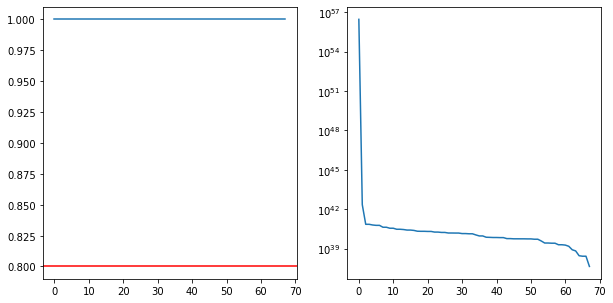

In [19]:
res = EigSorted(AmatCtrl)
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.plot(ComPercentFn(res[0]))
plt.axhline(0.8, color="red")
plt.subplot(122)
plt.plot(np.abs(res[0]))
plt.yscale("log")

In [20]:
ResCtrl = GetNewData(dXmatsCtrl, XmatsCtrl, AmatCtrl, paras.r, True)
ResAD_CtrlU = GetNewData(dXmatsAD, XmatsAD, AmatCtrl, paras.r, True)

In [21]:
canptssAD_CtrlU = Screening(ResAD_CtrlU.ndXmats, ResAD_CtrlU.nXmats, ResAD_CtrlU.kpidxs, wh=paras.wh, showProgress=True)
canptssCtrl = Screening(ResCtrl.ndXmats, ResCtrl.nXmats, ResCtrl.kpidxs, wh=paras.wh, showProgress=True)

Screening: 100%|██████████████████████████████████████████████████████████████████████████████████████| 88/88 [14:52<00:00, 10.15s/it]


In [22]:
detRessAD_CtrlU = []
for ix in trange(len(canptssAD_CtrlU)):
    res = EGenDy(ResAD_CtrlU.ndXmats[ix], ResAD_CtrlU.nXmats[ix], paras.kappa, ResAD_CtrlU.kpidxs, 
                 Lmin=paras.Lmin,  canpts=canptssAD_CtrlU[ix], MaxM=paras.MaxM, 
                 is_full=True,  showProgress=False)
    detRessAD_CtrlU.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [33:11<00:00, 22.63s/it]


In [23]:
detRessCtrl = []
for ix in trange(len(canptssCtrl)):
    res = EGenDy(ResCtrl.ndXmats[ix], ResCtrl.nXmats[ix], paras.kappa, ResCtrl.kpidxs, 
                 Lmin=paras.Lmin,  canpts=canptssCtrl[ix], MaxM=paras.MaxM, 
                 is_full=True,  showProgress=False)
    detRessCtrl.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [33:35<00:00, 22.91s/it]


In [26]:
filNam = paras.saveDir/paras2name(paras)
print(filNam)
filNam.exists()

is_detrendTrue__decimateRate5__T2__lamb1.00E-04__fct5.00E-01__downRate200__r20__Lmin200__MaxM20__kappa3.21E+00__wh20__L1.00E+02__nRks10__is_ProdTrue__L150.pkl


False

In [27]:
if not filNam.exists():
    resAll = edict()
    resAll.detRessAD_CtrlU = detRessAD_CtrlU
    resAll.detRessCtrl = detRessCtrl
    resAll.canptssAD_CtrlU = canptssAD_CtrlU
    resAll.canptssCtrl = canptssCtrl
    resAll.ResAD_CtrlU = ResAD_CtrlU
    resAll.ResCtrl = ResCtrl
    resAll.AmatCtrl = AmatCtrl
    resAll.paras = paras
    with open(filNam, "wb") as f:
        pickle.dump(resAll, f)
else:
    with open(filNam, "rb") as f:
        resAll = pickle.load(f)
        
    detRessAD_CtrlU = resAll.detRessAD_CtrlU
    detRessCtrl = resAll.detRessCtrl
    canptssAD_CtrlU = resAll.canptssAD_CtrlU
    canptssCtrl = resAll.canptssCtrl
    AmatCtrl = resAll.AmatCtrl
    ResAD_CtrlU = resAll.ResAD_CtrlU
    ResCtrl = resAll.ResCtrl
    
    
    

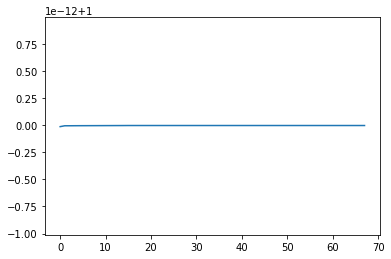

In [28]:
perRates = np.cumsum(np.abs(ResCtrl.eigVals))/np.sum(np.abs(ResCtrl.eigVals))
plt.plot(perRates)

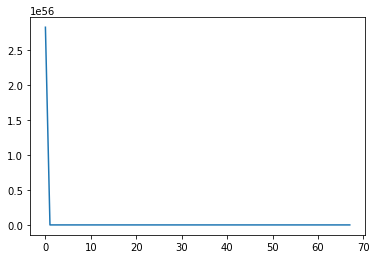

In [29]:
plt.plot(np.abs(ResCtrl.eigVals))

In [34]:
curKp = 3.30
_, curR, n = ResCtrl.ndXmats.shape
ecptssCtrl = np.array([UpdateKp(curKp, ix.U0, n, curR, paras) for ix in detRessCtrl])
_, curR, n = ResAD_CtrlU.ndXmats.shape
ecptssAD_CtrlU = np.array([UpdateKp(curKp, ix.U0, n, curR, paras) for ix in detRessAD_CtrlU])

In [35]:
print(np.mean(ecptssAD_CtrlU), np.mean(ecptssCtrl))
ttest_ind(ecptssAD_CtrlU, ecptssCtrl)

3.2386363636363638 6.193181818181818


Ttest_indResult(statistic=-6.969940201483192, pvalue=6.303794129241764e-11)

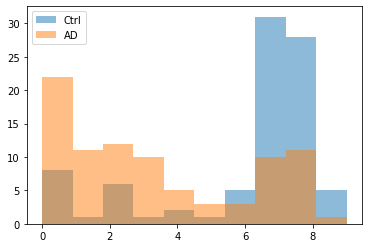

In [36]:
plt.hist(ecptssCtrl, alpha=0.5, label="Ctrl")
plt.hist(ecptssAD_CtrlU, alpha=0.5, label="AD")
plt.legend()

In [38]:
def euclidean_proj_l1ball_Cplx(curVal, L):
    curValAbs = np.abs(curVal)
    redValAbs = euclidean_proj_l1ball(curValAbs.copy(), L)
    ratioValAbs = redValAbs/curValAbs
    redVal = curVal * ratioValAbs
    return redVal

def euclidean_proj_l1ball_CplxMat(curMat, L):
    curMatAbs = np.abs(curMat)
    rowNorms = np.sum(np.abs(curMatAbs), axis=1)
    redRowNorms = euclidean_proj_l1ball(rowNorms.copy(), L)
    rowNorms[rowNorms==0] = 1e-5 # avoid divided-by-0 error
    ratioVec = redRowNorms/rowNorms
    curMatRed = ratioVec.reshape(-1, 1) * curMat
    return curMatRed, redRowNorms

def euclidean_proj_l1ball_CplxMul(eigValsMat, L1):
    singleRedCurValList = []
    for ix in range(eigValsMat.shape[-1]):
        curVal = eigValsMat[:, ix]
        redCurVal = euclidean_proj_l1ball_Cplx(curVal.copy(), L1)
        singleRedCurValList.append(redCurVal)
    singleRedCurValMat = np.array(singleRedCurValList).T
    return singleRedCurValMat

In [39]:
paras.L1 = 25
paras.L = 50

rksCtrl = []
kpidxs = ResCtrl.kpidxs
for ix in range(len(detRessCtrl)):
    ndXmat = ResCtrl.ndXmats[ix]
    nXmat = ResCtrl.nXmats[ix]
    necpts = ecptssCtrl[ix]
    ecpts = detRessCtrl[ix].chgMat[necpts-1, :necpts]
    eigValsMat = estEigVals(ecpts, ndXmat, nXmat, kpidxs)
    eigValsMat = euclidean_proj_l1ball_CplxMul(eigValsMat, paras.L1)
    _, redRowNorms = euclidean_proj_l1ball_CplxMat(eigValsMat, paras.L)
    curKpidxs = np.intersect1d(np.where(redRowNorms!=0)[0], kpidxs)
    
    curRk = np.sum(redRowNorms != 0)
    rksCtrl.append(curRk)

In [40]:
rksAD_CtrlU= []
kpidxs = ResAD_CtrlU.kpidxs
for ix in range(len(detRessAD_CtrlU)):
    ndXmat = ResAD_CtrlU.ndXmats[ix]
    nXmat = ResAD_CtrlU.nXmats[ix]
    necpts = ecptssAD_CtrlU[ix]
    ecpts = detRessAD_CtrlU[ix].chgMat[necpts-1, :necpts]
    eigValsMat = estEigVals(ecpts, ndXmat, nXmat, kpidxs)
    eigValsMat = euclidean_proj_l1ball_CplxMul(eigValsMat, paras.L1)
    _, redRowNorms = euclidean_proj_l1ball_CplxMat(eigValsMat, paras.L)
    curKpidxs = np.intersect1d(np.where(redRowNorms!=0)[0], kpidxs)
    
    curRk = np.sum(redRowNorms != 0)
    rksAD_CtrlU.append(curRk)
    #print(np.std(redRowNorms))

11.693181818181818 10.102272727272727
Ttest_indResult(statistic=2.4982150994797383, pvalue=0.013409903614300014)


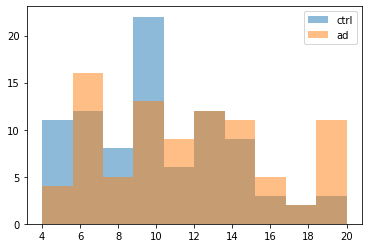

In [41]:
print(np.mean(rksAD_CtrlU), np.mean(rksCtrl))
print(ttest_ind(rksAD_CtrlU, rksCtrl))
plt.hist(rksCtrl, alpha=0.5, label="ctrl")
plt.hist(rksAD_CtrlU, alpha=0.5, label="ad")
plt.legend()


### Use combined U for AD and Ctrl 

In [53]:
BothDats = np.concatenate([ADDats, CtrlDats], axis=0)
YmatBoth = prepMEG(BothDats, paras)

In [54]:
timeSpan = np.linspace(0, paras.T, YmatBoth.shape[-1])
dXmatsBoth, XmatsBoth = GetBsplineEst(YmatBoth, timeSpan, paras.lamb)


100%|██████████| 157/157 [00:57<00:00,  2.73it/s]


In [55]:
AmatBoth = GetAmat(dXmatsBoth, XmatsBoth, timeSpan, downrate=paras.downRate, fct=paras.fct, is_sum=True)
ResCtrl_comU = GetNewData(dXmatsCtrl, XmatsCtrl, AmatBoth, paras.r, True)
ResAD_comU = GetNewData(dXmatsAD, XmatsAD, AmatBoth, paras.r, True)


100%|██████████| 157/157 [01:29<00:00,  1.76it/s]


In [56]:
canptssAD_comU = Screening(ResAD_comU.ndXmats, ResAD_comU.nXmats, wh=paras.wh, showProgress=True)
canptssCtrl_comU = Screening(ResCtrl_comU.ndXmats, ResCtrl_comU.nXmats, wh=paras.wh, showProgress=True)


Screening: 100%|██████████| 87/87 [10:39<00:00,  7.36s/it]

Screening: 100%|██████████| 70/70 [08:34<00:00,  7.36s/it]


In [ ]:
detRessAD_comU = []
for ix in trange(len(canptssAD_comU)):
    res = EGenDy(ResAD_comU.ndXmats[ix], ResAD_comU.nXmats[ix], paras.kappa, Lmin=paras.Lmin, 
          canpts=canptssAD_comU[ix], MaxM=paras.MaxM, is_full=True, 
          showProgress=True)
    detRessAD_comU.append(res)


  0%|          | 0/87 [00:00<?, ?it/s]

Dynamic Programming:   0%|          | 0/186 [00:00<?, ?it/s]

Dynamic Programming:   1%|          | 1/186 [00:00<01:34,  1.97it/s]

Dynamic Programming:   1%|          | 2/186 [00:01<01:34,  1.95it/s]

Dynamic Programming:   2%|▏         | 3/186 [00:01<01:33,  1.97it/s]

Dynamic Programming:   2%|▏         | 4/186 [00:02<01:31,  1.99it/s]

Dynamic Programming:   3%|▎         | 5/186 [00:02<01:31,  1.98it/s]

Dynamic Programming:   3%|▎         | 6/186 [00:03<01:29,  2.01it/s]

Dynamic Programming:   4%|▍         | 7/186 [00:03<01:29,  2.01it/s]

Dynamic Programming:   4%|▍         | 8/186 [00:03<01:27,  2.03it/s]

Dynamic Programming:   5%|▍         | 9/186 [00:04<01:26,  2.03it/s]

Dynamic Programming:   5%|▌         | 10/186 [00:04<01:25,  2.07it/s]

Dynamic Programming:   6%|▌         | 11/186 [00:05<01:24,  2.07it/s]

Dynamic Programming:   6%|▋         | 12/186 [00:05<01:22,  2.10it/s]

Dynamic Programming:   7%|▋         | 13/186 [00:06<01

Dynamic Programming:  57%|█████▋    | 106/186 [00:32<00:11,  6.90it/s]

Dynamic Programming:  58%|█████▊    | 107/186 [00:32<00:11,  7.10it/s]

Dynamic Programming:  58%|█████▊    | 108/186 [00:32<00:10,  7.29it/s]

Dynamic Programming:  59%|█████▊    | 109/186 [00:33<00:10,  7.46it/s]

Dynamic Programming:  59%|█████▉    | 110/186 [00:33<00:09,  7.61it/s]

Dynamic Programming:  60%|█████▉    | 111/186 [00:33<00:09,  7.77it/s]

Dynamic Programming:  60%|██████    | 112/186 [00:33<00:09,  7.56it/s]

Dynamic Programming:  61%|██████    | 113/186 [00:33<00:09,  7.83it/s]

Dynamic Programming:  61%|██████▏   | 114/186 [00:33<00:08,  8.09it/s]

Dynamic Programming:  62%|██████▏   | 115/186 [00:33<00:08,  8.33it/s]

Dynamic Programming:  62%|██████▏   | 116/186 [00:33<00:08,  8.46it/s]

Dynamic Programming:  63%|██████▎   | 117/186 [00:33<00:07,  8.74it/s]

Dynamic Programming:  63%|██████▎   | 118/186 [00:34<00:07,  8.99it/s]

Dynamic Programming:  64%|██████▍   | 119/186 [00:34<00:07,  9.2

Dynamic Programming:  15%|█▍        | 29/198 [00:14<01:14,  2.28it/s]

Dynamic Programming:  15%|█▌        | 30/198 [00:14<01:12,  2.32it/s]

Dynamic Programming:  16%|█▌        | 31/198 [00:15<01:12,  2.31it/s]

Dynamic Programming:  16%|█▌        | 32/198 [00:15<01:10,  2.35it/s]

Dynamic Programming:  17%|█▋        | 33/198 [00:15<01:09,  2.36it/s]

Dynamic Programming:  17%|█▋        | 34/198 [00:16<01:08,  2.40it/s]

Dynamic Programming:  18%|█▊        | 35/198 [00:16<01:06,  2.44it/s]

Dynamic Programming:  18%|█▊        | 36/198 [00:17<01:06,  2.43it/s]

Dynamic Programming:  19%|█▊        | 37/198 [00:17<01:04,  2.48it/s]

Dynamic Programming:  19%|█▉        | 38/198 [00:17<01:04,  2.48it/s]

Dynamic Programming:  20%|█▉        | 39/198 [00:18<01:02,  2.53it/s]

Dynamic Programming:  20%|██        | 40/198 [00:18<01:01,  2.57it/s]

Dynamic Programming:  21%|██        | 41/198 [00:19<01:01,  2.57it/s]

Dynamic Programming:  21%|██        | 42/198 [00:19<00:59,  2.62it/s]

Dynami

Dynamic Programming:  45%|████▍     | 89/199 [00:33<00:24,  4.47it/s]

Dynamic Programming:  45%|████▌     | 90/199 [00:33<00:23,  4.58it/s]

Dynamic Programming:  46%|████▌     | 91/199 [00:33<00:22,  4.70it/s]

Dynamic Programming:  46%|████▌     | 92/199 [00:33<00:22,  4.80it/s]

Dynamic Programming:  47%|████▋     | 93/199 [00:33<00:21,  4.89it/s]

Dynamic Programming:  47%|████▋     | 94/199 [00:34<00:21,  4.85it/s]

Dynamic Programming:  48%|████▊     | 95/199 [00:34<00:20,  4.96it/s]

Dynamic Programming:  48%|████▊     | 96/199 [00:34<00:20,  5.07it/s]

Dynamic Programming:  49%|████▊     | 97/199 [00:34<00:19,  5.19it/s]

Dynamic Programming:  49%|████▉     | 98/199 [00:34<00:19,  5.29it/s]

Dynamic Programming:  50%|████▉     | 99/199 [00:35<00:18,  5.39it/s]

Dynamic Programming:  50%|█████     | 100/199 [00:35<00:18,  5.31it/s]

Dynamic Programming:  51%|█████     | 101/199 [00:35<00:17,  5.48it/s]

Dynamic Programming:  51%|█████▏    | 102/199 [00:35<00:17,  5.63it/s]

Dyn

Dynamic Programming: 100%|██████████| 196/196 [00:40<00:00,  4.86it/s]

  6%|▌         | 5/87 [03:21<54:46, 40.08s/it]

Dynamic Programming:   0%|          | 0/198 [00:00<?, ?it/s]

Dynamic Programming:   1%|          | 1/198 [00:00<01:48,  1.82it/s]

Dynamic Programming:   1%|          | 2/198 [00:01<01:47,  1.82it/s]

Dynamic Programming:   2%|▏         | 3/198 [00:01<01:47,  1.81it/s]

Dynamic Programming:   2%|▏         | 4/198 [00:02<01:47,  1.81it/s]

Dynamic Programming:   3%|▎         | 5/198 [00:02<01:45,  1.84it/s]

Dynamic Programming:   3%|▎         | 6/198 [00:03<01:44,  1.84it/s]

Dynamic Programming:   4%|▎         | 7/198 [00:03<01:42,  1.87it/s]

Dynamic Programming:   4%|▍         | 8/198 [00:04<01:41,  1.87it/s]

Dynamic Programming:   5%|▍         | 9/198 [00:04<01:39,  1.90it/s]

Dynamic Programming:   5%|▌         | 10/198 [00:05<01:38,  1.91it/s]

Dynamic Programming:   6%|▌         | 11/198 [00:05<01:36,  1.94it/s]

Dynamic Programming:   6%|▌         | 12/198 [

Dynamic Programming:  30%|███       | 60/197 [00:25<00:42,  3.25it/s]

Dynamic Programming:  31%|███       | 61/197 [00:25<00:41,  3.31it/s]

Dynamic Programming:  31%|███▏      | 62/197 [00:25<00:40,  3.32it/s]

Dynamic Programming:  32%|███▏      | 63/197 [00:26<00:39,  3.38it/s]

Dynamic Programming:  32%|███▏      | 64/197 [00:26<00:38,  3.44it/s]

Dynamic Programming:  33%|███▎      | 65/197 [00:26<00:38,  3.46it/s]

Dynamic Programming:  34%|███▎      | 66/197 [00:26<00:37,  3.52it/s]

Dynamic Programming:  34%|███▍      | 67/197 [00:27<00:36,  3.57it/s]

Dynamic Programming:  35%|███▍      | 68/197 [00:27<00:35,  3.63it/s]

Dynamic Programming:  35%|███▌      | 69/197 [00:27<00:35,  3.59it/s]

Dynamic Programming:  36%|███▌      | 70/197 [00:28<00:34,  3.67it/s]

Dynamic Programming:  36%|███▌      | 71/197 [00:28<00:33,  3.73it/s]

Dynamic Programming:  37%|███▋      | 72/197 [00:28<00:32,  3.79it/s]

Dynamic Programming:  37%|███▋      | 73/197 [00:28<00:33,  3.76it/s]

Dynami

Dynamic Programming:  70%|██████▉   | 128/183 [00:34<00:04, 11.29it/s]

Dynamic Programming:  71%|███████   | 130/183 [00:34<00:04, 12.01it/s]

Dynamic Programming:  72%|███████▏  | 132/183 [00:34<00:03, 12.78it/s]

Dynamic Programming:  73%|███████▎  | 134/183 [00:34<00:03, 13.59it/s]

Dynamic Programming:  74%|███████▍  | 136/183 [00:34<00:03, 14.39it/s]

Dynamic Programming:  75%|███████▌  | 138/183 [00:34<00:02, 15.26it/s]

Dynamic Programming:  77%|███████▋  | 140/183 [00:34<00:02, 16.27it/s]

Dynamic Programming:  78%|███████▊  | 143/183 [00:35<00:02, 17.49it/s]

Dynamic Programming:  79%|███████▉  | 145/183 [00:35<00:02, 17.79it/s]

Dynamic Programming:  81%|████████  | 148/183 [00:35<00:01, 19.52it/s]

Dynamic Programming:  83%|████████▎ | 151/183 [00:35<00:01, 21.53it/s]

Dynamic Programming:  85%|████████▍ | 155/183 [00:35<00:01, 24.02it/s]

Dynamic Programming:  87%|████████▋ | 159/183 [00:35<00:00, 27.26it/s]

Dynamic Programming:  90%|█████████ | 165/183 [00:35<00:00, 31.8

Dynamic Programming:  26%|██▌       | 51/197 [00:22<00:50,  2.88it/s]

Dynamic Programming:  26%|██▋       | 52/197 [00:22<00:49,  2.93it/s]

Dynamic Programming:  27%|██▋       | 53/197 [00:22<00:48,  2.98it/s]

Dynamic Programming:  27%|██▋       | 54/197 [00:23<00:48,  2.97it/s]

Dynamic Programming:  28%|██▊       | 55/197 [00:23<00:46,  3.02it/s]

Dynamic Programming:  28%|██▊       | 56/197 [00:23<00:45,  3.07it/s]

Dynamic Programming:  29%|██▉       | 57/197 [00:24<00:45,  3.07it/s]

Dynamic Programming:  29%|██▉       | 58/197 [00:24<00:44,  3.14it/s]

Dynamic Programming:  30%|██▉       | 59/197 [00:24<00:43,  3.20it/s]

Dynamic Programming:  30%|███       | 60/197 [00:25<00:42,  3.21it/s]

Dynamic Programming:  31%|███       | 61/197 [00:25<00:41,  3.28it/s]

Dynamic Programming:  31%|███▏      | 62/197 [00:25<00:40,  3.33it/s]

Dynamic Programming:  32%|███▏      | 63/197 [00:26<00:39,  3.39it/s]

Dynamic Programming:  32%|███▏      | 64/197 [00:26<00:39,  3.36it/s]

Dynami

Dynamic Programming:  55%|█████▌    | 112/202 [00:37<00:14,  6.41it/s]

Dynamic Programming:  56%|█████▌    | 113/202 [00:37<00:13,  6.55it/s]

Dynamic Programming:  56%|█████▋    | 114/202 [00:38<00:13,  6.68it/s]

Dynamic Programming:  57%|█████▋    | 115/202 [00:38<00:12,  6.81it/s]

Dynamic Programming:  57%|█████▋    | 116/202 [00:38<00:12,  6.93it/s]

Dynamic Programming:  58%|█████▊    | 117/202 [00:38<00:12,  6.75it/s]

Dynamic Programming:  58%|█████▊    | 118/202 [00:38<00:12,  6.95it/s]

Dynamic Programming:  59%|█████▉    | 119/202 [00:38<00:11,  7.13it/s]

Dynamic Programming:  59%|█████▉    | 120/202 [00:38<00:11,  7.30it/s]

Dynamic Programming:  60%|█████▉    | 121/202 [00:39<00:10,  7.46it/s]

Dynamic Programming:  60%|██████    | 122/202 [00:39<00:10,  7.62it/s]

Dynamic Programming:  61%|██████    | 123/202 [00:39<00:10,  7.76it/s]

Dynamic Programming:  61%|██████▏   | 124/202 [00:39<00:09,  7.91it/s]

Dynamic Programming:  62%|██████▏   | 125/202 [00:39<00:10,  7.6

Dynamic Programming:  10%|█         | 20/191 [00:09<01:19,  2.16it/s]

Dynamic Programming:  11%|█         | 21/191 [00:10<01:18,  2.16it/s]

Dynamic Programming:  12%|█▏        | 22/191 [00:10<01:17,  2.19it/s]

Dynamic Programming:  12%|█▏        | 23/191 [00:11<01:16,  2.20it/s]

Dynamic Programming:  13%|█▎        | 24/191 [00:11<01:14,  2.23it/s]

Dynamic Programming:  13%|█▎        | 25/191 [00:12<01:13,  2.26it/s]

Dynamic Programming:  14%|█▎        | 26/191 [00:12<01:13,  2.26it/s]

Dynamic Programming:  14%|█▍        | 27/191 [00:13<01:11,  2.29it/s]

Dynamic Programming:  15%|█▍        | 28/191 [00:13<01:11,  2.29it/s]

Dynamic Programming:  15%|█▌        | 29/191 [00:13<01:09,  2.35it/s]

Dynamic Programming:  16%|█▌        | 30/191 [00:14<01:08,  2.36it/s]

Dynamic Programming:  16%|█▌        | 31/191 [00:14<01:06,  2.41it/s]

Dynamic Programming:  17%|█▋        | 32/191 [00:15<01:04,  2.45it/s]

Dynamic Programming:  17%|█▋        | 33/191 [00:15<01:04,  2.45it/s]

Dynami

Dynamic Programming:  46%|████▌     | 87/191 [00:30<00:21,  4.80it/s]

Dynamic Programming:  46%|████▌     | 88/191 [00:31<00:20,  4.92it/s]

Dynamic Programming:  47%|████▋     | 89/191 [00:31<00:20,  5.03it/s]

Dynamic Programming:  47%|████▋     | 90/191 [00:31<00:19,  5.13it/s]

Dynamic Programming:  48%|████▊     | 91/191 [00:31<00:19,  5.23it/s]

Dynamic Programming:  48%|████▊     | 92/191 [00:31<00:19,  5.14it/s]

Dynamic Programming:  49%|████▊     | 93/191 [00:32<00:18,  5.28it/s]

Dynamic Programming:  49%|████▉     | 94/191 [00:32<00:17,  5.41it/s]

Dynamic Programming:  50%|████▉     | 95/191 [00:32<00:17,  5.53it/s]

Dynamic Programming:  50%|█████     | 96/191 [00:32<00:16,  5.65it/s]

Dynamic Programming:  51%|█████     | 97/191 [00:32<00:16,  5.75it/s]

Dynamic Programming:  51%|█████▏    | 98/191 [00:32<00:16,  5.64it/s]

Dynamic Programming:  52%|█████▏    | 99/191 [00:33<00:15,  5.80it/s]

Dynamic Programming:  52%|█████▏    | 100/191 [00:33<00:15,  5.95it/s]

Dynam

Dynamic Programming:   1%|▏         | 3/201 [00:01<01:52,  1.76it/s]

Dynamic Programming:   2%|▏         | 4/201 [00:02<01:51,  1.76it/s]

Dynamic Programming:   2%|▏         | 5/201 [00:02<01:49,  1.78it/s]

Dynamic Programming:   3%|▎         | 6/201 [00:03<01:49,  1.79it/s]

Dynamic Programming:   3%|▎         | 7/201 [00:03<01:47,  1.81it/s]

Dynamic Programming:   4%|▍         | 8/201 [00:04<01:46,  1.81it/s]

Dynamic Programming:   4%|▍         | 9/201 [00:04<01:45,  1.83it/s]

Dynamic Programming:   5%|▍         | 10/201 [00:05<01:44,  1.83it/s]

Dynamic Programming:   5%|▌         | 11/201 [00:06<01:41,  1.86it/s]

Dynamic Programming:   6%|▌         | 12/201 [00:06<01:41,  1.87it/s]

Dynamic Programming:   6%|▋         | 13/201 [00:07<01:38,  1.90it/s]

Dynamic Programming:   7%|▋         | 14/201 [00:07<01:38,  1.91it/s]

Dynamic Programming:   7%|▋         | 15/201 [00:08<01:36,  1.93it/s]

Dynamic Programming:   8%|▊         | 16/201 [00:08<01:35,  1.94it/s]

Dynamic Progr

Dynamic Programming:  31%|███       | 60/196 [00:25<00:42,  3.20it/s]

Dynamic Programming:  31%|███       | 61/196 [00:25<00:41,  3.26it/s]

Dynamic Programming:  32%|███▏      | 62/196 [00:25<00:40,  3.31it/s]

Dynamic Programming:  32%|███▏      | 63/196 [00:26<00:39,  3.36it/s]

Dynamic Programming:  33%|███▎      | 64/196 [00:26<00:39,  3.34it/s]

Dynamic Programming:  33%|███▎      | 65/196 [00:26<00:38,  3.42it/s]

Dynamic Programming:  34%|███▎      | 66/196 [00:26<00:37,  3.49it/s]

Dynamic Programming:  34%|███▍      | 67/196 [00:27<00:37,  3.49it/s]

Dynamic Programming:  35%|███▍      | 68/196 [00:27<00:35,  3.57it/s]

Dynamic Programming:  35%|███▌      | 69/196 [00:27<00:34,  3.64it/s]

Dynamic Programming:  36%|███▌      | 70/196 [00:27<00:33,  3.71it/s]

Dynamic Programming:  36%|███▌      | 71/196 [00:28<00:33,  3.69it/s]

Dynamic Programming:  37%|███▋      | 72/196 [00:28<00:32,  3.78it/s]

Dynamic Programming:  37%|███▋      | 73/196 [00:28<00:31,  3.85it/s]

Dynami

Dynamic Programming:  62%|██████▏   | 122/197 [00:37<00:08,  8.40it/s]

Dynamic Programming:  62%|██████▏   | 123/197 [00:37<00:08,  8.56it/s]

Dynamic Programming:  63%|██████▎   | 124/197 [00:37<00:08,  8.74it/s]

Dynamic Programming:  63%|██████▎   | 125/197 [00:37<00:08,  8.92it/s]

Dynamic Programming:  64%|██████▍   | 126/197 [00:37<00:07,  9.10it/s]

Dynamic Programming:  64%|██████▍   | 127/197 [00:37<00:07,  8.79it/s]

Dynamic Programming:  65%|██████▍   | 128/197 [00:37<00:07,  9.12it/s]

Dynamic Programming:  66%|██████▌   | 130/197 [00:38<00:07,  9.47it/s]

Dynamic Programming:  67%|██████▋   | 132/197 [00:38<00:06,  9.84it/s]

Dynamic Programming:  68%|██████▊   | 134/197 [00:38<00:06, 10.24it/s]

Dynamic Programming:  69%|██████▉   | 136/197 [00:38<00:05, 10.67it/s]

Dynamic Programming:  70%|███████   | 138/197 [00:38<00:05, 10.75it/s]

Dynamic Programming:  71%|███████   | 140/197 [00:39<00:04, 11.41it/s]

Dynamic Programming:  72%|███████▏  | 142/197 [00:39<00:04, 12.0

Dynamic Programming:  15%|█▌        | 31/203 [00:15<01:15,  2.28it/s]

Dynamic Programming:  16%|█▌        | 32/203 [00:15<01:13,  2.32it/s]

Dynamic Programming:  16%|█▋        | 33/203 [00:16<01:13,  2.32it/s]

Dynamic Programming:  17%|█▋        | 34/203 [00:16<01:12,  2.34it/s]

Dynamic Programming:  17%|█▋        | 35/203 [00:17<01:10,  2.39it/s]

Dynamic Programming:  18%|█▊        | 36/203 [00:17<01:09,  2.39it/s]

Dynamic Programming:  18%|█▊        | 37/203 [00:17<01:08,  2.43it/s]

Dynamic Programming:  19%|█▊        | 38/203 [00:18<01:07,  2.45it/s]

Dynamic Programming:  19%|█▉        | 39/203 [00:18<01:05,  2.49it/s]

Dynamic Programming:  20%|█▉        | 40/203 [00:19<01:04,  2.53it/s]

Dynamic Programming:  20%|██        | 41/203 [00:19<01:04,  2.52it/s]

Dynamic Programming:  21%|██        | 42/203 [00:19<01:02,  2.57it/s]

Dynamic Programming:  21%|██        | 43/203 [00:20<01:01,  2.62it/s]

Dynamic Programming:  22%|██▏       | 44/203 [00:20<01:00,  2.61it/s]

Dynami

Dynamic Programming:  46%|████▌     | 88/191 [00:31<00:20,  4.99it/s]

Dynamic Programming:  47%|████▋     | 89/191 [00:31<00:20,  5.08it/s]

Dynamic Programming:  47%|████▋     | 90/191 [00:31<00:20,  5.00it/s]

Dynamic Programming:  48%|████▊     | 91/191 [00:31<00:19,  5.13it/s]

Dynamic Programming:  48%|████▊     | 92/191 [00:32<00:18,  5.25it/s]

Dynamic Programming:  49%|████▊     | 93/191 [00:32<00:18,  5.36it/s]

Dynamic Programming:  49%|████▉     | 94/191 [00:32<00:17,  5.47it/s]

Dynamic Programming:  50%|████▉     | 95/191 [00:32<00:17,  5.59it/s]

Dynamic Programming:  50%|█████     | 96/191 [00:32<00:17,  5.57it/s]

Dynamic Programming:  51%|█████     | 97/191 [00:33<00:16,  5.72it/s]

Dynamic Programming:  51%|█████▏    | 98/191 [00:33<00:15,  5.86it/s]

Dynamic Programming:  52%|█████▏    | 99/191 [00:33<00:15,  5.99it/s]

Dynamic Programming:  52%|█████▏    | 100/191 [00:33<00:15,  6.00it/s]

Dynamic Programming:  53%|█████▎    | 101/191 [00:33<00:14,  6.14it/s]

Dyna

Dynamic Programming:   5%|▌         | 10/197 [00:05<01:38,  1.91it/s]

Dynamic Programming:   6%|▌         | 11/197 [00:05<01:35,  1.94it/s]

Dynamic Programming:   6%|▌         | 12/197 [00:06<01:35,  1.95it/s]

Dynamic Programming:   7%|▋         | 13/197 [00:06<01:32,  1.98it/s]

Dynamic Programming:   7%|▋         | 14/197 [00:07<01:31,  1.99it/s]

Dynamic Programming:   8%|▊         | 15/197 [00:07<01:29,  2.02it/s]

Dynamic Programming:   8%|▊         | 16/197 [00:08<01:29,  2.03it/s]

Dynamic Programming:   9%|▊         | 17/197 [00:08<01:27,  2.07it/s]

Dynamic Programming:   9%|▉         | 18/197 [00:09<01:25,  2.10it/s]

Dynamic Programming:  10%|▉         | 19/197 [00:09<01:24,  2.10it/s]

Dynamic Programming:  10%|█         | 20/197 [00:10<01:22,  2.13it/s]

Dynamic Programming:  11%|█         | 21/197 [00:10<01:22,  2.13it/s]

Dynamic Programming:  11%|█         | 22/197 [00:11<01:20,  2.17it/s]

Dynamic Programming:  12%|█▏        | 23/197 [00:11<01:20,  2.17it/s]

Dynami

Dynamic Programming:  36%|███▌      | 71/199 [00:28<00:35,  3.58it/s]

Dynamic Programming:  36%|███▌      | 72/199 [00:28<00:34,  3.67it/s]

Dynamic Programming:  37%|███▋      | 73/199 [00:29<00:33,  3.75it/s]

Dynamic Programming:  37%|███▋      | 74/199 [00:29<00:32,  3.82it/s]

Dynamic Programming:  38%|███▊      | 75/199 [00:29<00:32,  3.79it/s]

Dynamic Programming:  38%|███▊      | 76/199 [00:29<00:31,  3.88it/s]

Dynamic Programming:  39%|███▊      | 77/199 [00:30<00:30,  3.96it/s]

Dynamic Programming:  39%|███▉      | 78/199 [00:30<00:30,  4.03it/s]

Dynamic Programming:  40%|███▉      | 79/199 [00:30<00:30,  3.99it/s]

Dynamic Programming:  40%|████      | 80/199 [00:30<00:29,  4.09it/s]

Dynamic Programming:  41%|████      | 81/199 [00:31<00:28,  4.17it/s]

Dynamic Programming:  41%|████      | 82/199 [00:31<00:27,  4.25it/s]

Dynamic Programming:  42%|████▏     | 83/199 [00:31<00:26,  4.32it/s]

Dynamic Programming:  42%|████▏     | 84/199 [00:31<00:26,  4.29it/s]

Dynami

Dynamic Programming:  69%|██████▉   | 135/196 [00:38<00:05, 10.30it/s]

Dynamic Programming:  70%|██████▉   | 137/196 [00:38<00:05, 10.77it/s]

Dynamic Programming:  71%|███████   | 139/196 [00:38<00:05, 11.24it/s]

Dynamic Programming:  72%|███████▏  | 141/196 [00:39<00:04, 11.73it/s]

Dynamic Programming:  73%|███████▎  | 143/196 [00:39<00:04, 11.78it/s]

Dynamic Programming:  74%|███████▍  | 145/196 [00:39<00:04, 12.41it/s]

Dynamic Programming:  75%|███████▌  | 147/196 [00:39<00:03, 13.22it/s]

Dynamic Programming:  76%|███████▌  | 149/196 [00:39<00:03, 14.10it/s]

Dynamic Programming:  77%|███████▋  | 151/196 [00:39<00:02, 15.02it/s]

Dynamic Programming:  78%|███████▊  | 153/196 [00:39<00:02, 16.01it/s]

Dynamic Programming:  79%|███████▉  | 155/196 [00:39<00:02, 17.01it/s]

Dynamic Programming:  81%|████████  | 158/196 [00:40<00:02, 18.13it/s]

Dynamic Programming:  82%|████████▏ | 161/196 [00:40<00:01, 19.70it/s]

Dynamic Programming:  84%|████████▎ | 164/196 [00:40<00:01, 20.6

Dynamic Programming:  22%|██▏       | 43/198 [00:19<00:58,  2.66it/s]

Dynamic Programming:  22%|██▏       | 44/198 [00:19<00:56,  2.71it/s]

Dynamic Programming:  23%|██▎       | 45/198 [00:20<00:56,  2.71it/s]

Dynamic Programming:  23%|██▎       | 46/198 [00:20<00:54,  2.76it/s]

Dynamic Programming:  24%|██▎       | 47/198 [00:20<00:53,  2.81it/s]

Dynamic Programming:  24%|██▍       | 48/198 [00:21<00:53,  2.80it/s]

Dynamic Programming:  25%|██▍       | 49/198 [00:21<00:52,  2.86it/s]

Dynamic Programming:  25%|██▌       | 50/198 [00:21<00:50,  2.91it/s]

Dynamic Programming:  26%|██▌       | 51/198 [00:22<00:50,  2.90it/s]

Dynamic Programming:  26%|██▋       | 52/198 [00:22<00:49,  2.95it/s]

Dynamic Programming:  27%|██▋       | 53/198 [00:22<00:48,  3.00it/s]

Dynamic Programming:  27%|██▋       | 54/198 [00:23<00:47,  3.04it/s]

Dynamic Programming:  28%|██▊       | 55/198 [00:23<00:46,  3.09it/s]

Dynamic Programming:  28%|██▊       | 56/198 [00:23<00:45,  3.13it/s]

Dynami

Dynamic Programming:  51%|█████     | 103/202 [00:36<00:17,  5.57it/s]

Dynamic Programming:  51%|█████▏    | 104/202 [00:36<00:17,  5.68it/s]

Dynamic Programming:  52%|█████▏    | 105/202 [00:36<00:16,  5.78it/s]

Dynamic Programming:  52%|█████▏    | 106/202 [00:36<00:16,  5.67it/s]

Dynamic Programming:  53%|█████▎    | 107/202 [00:36<00:16,  5.83it/s]

Dynamic Programming:  53%|█████▎    | 108/202 [00:36<00:15,  5.98it/s]

Dynamic Programming:  54%|█████▍    | 109/202 [00:37<00:15,  6.12it/s]

Dynamic Programming:  54%|█████▍    | 110/202 [00:37<00:14,  6.18it/s]

Dynamic Programming:  55%|█████▍    | 111/202 [00:37<00:14,  6.33it/s]

Dynamic Programming:  55%|█████▌    | 112/202 [00:37<00:14,  6.20it/s]

Dynamic Programming:  56%|█████▌    | 113/202 [00:37<00:13,  6.39it/s]

Dynamic Programming:  56%|█████▋    | 114/202 [00:37<00:13,  6.55it/s]

Dynamic Programming:  57%|█████▋    | 115/202 [00:37<00:12,  6.70it/s]

Dynamic Programming:  57%|█████▋    | 116/202 [00:38<00:12,  6.8

Dynamic Programming:   6%|▌         | 12/198 [00:06<01:36,  1.93it/s]

Dynamic Programming:   7%|▋         | 13/198 [00:06<01:34,  1.96it/s]

Dynamic Programming:   7%|▋         | 14/198 [00:07<01:33,  1.96it/s]

Dynamic Programming:   8%|▊         | 15/198 [00:07<01:32,  1.99it/s]

Dynamic Programming:   8%|▊         | 16/198 [00:08<01:31,  1.99it/s]

Dynamic Programming:   9%|▊         | 17/198 [00:08<01:29,  2.02it/s]

Dynamic Programming:   9%|▉         | 18/198 [00:09<01:28,  2.02it/s]

Dynamic Programming:  10%|▉         | 19/198 [00:09<01:26,  2.06it/s]

Dynamic Programming:  10%|█         | 20/198 [00:10<01:26,  2.06it/s]

Dynamic Programming:  11%|█         | 21/198 [00:10<01:24,  2.09it/s]

Dynamic Programming:  11%|█         | 22/198 [00:11<01:23,  2.10it/s]

Dynamic Programming:  12%|█▏        | 23/198 [00:11<01:22,  2.13it/s]

Dynamic Programming:  12%|█▏        | 24/198 [00:12<01:21,  2.14it/s]

Dynamic Programming:  13%|█▎        | 25/198 [00:12<01:19,  2.17it/s]

Dynami

Dynamic Programming:  39%|███▊      | 74/191 [00:27<00:28,  4.15it/s]

Dynamic Programming:  39%|███▉      | 75/191 [00:28<00:27,  4.22it/s]

Dynamic Programming:  40%|███▉      | 76/191 [00:28<00:26,  4.29it/s]

Dynamic Programming:  40%|████      | 77/191 [00:28<00:26,  4.24it/s]

Dynamic Programming:  41%|████      | 78/191 [00:28<00:26,  4.34it/s]

Dynamic Programming:  41%|████▏     | 79/191 [00:28<00:25,  4.43it/s]

Dynamic Programming:  42%|████▏     | 80/191 [00:29<00:24,  4.50it/s]

Dynamic Programming:  42%|████▏     | 81/191 [00:29<00:24,  4.51it/s]

Dynamic Programming:  43%|████▎     | 82/191 [00:29<00:23,  4.59it/s]

Dynamic Programming:  43%|████▎     | 83/191 [00:29<00:23,  4.67it/s]

Dynamic Programming:  44%|████▍     | 84/191 [00:30<00:22,  4.75it/s]

Dynamic Programming:  45%|████▍     | 85/191 [00:30<00:21,  4.85it/s]

Dynamic Programming:  45%|████▌     | 86/191 [00:30<00:21,  4.78it/s]

Dynamic Programming:  46%|████▌     | 87/191 [00:30<00:21,  4.91it/s]

Dynami

Dynamic Programming:  79%|███████▊  | 155/197 [00:39<00:02, 16.11it/s]

Dynamic Programming:  80%|████████  | 158/197 [00:39<00:02, 17.21it/s]

Dynamic Programming:  82%|████████▏ | 161/197 [00:40<00:01, 18.48it/s]

Dynamic Programming:  83%|████████▎ | 164/197 [00:40<00:01, 20.18it/s]

Dynamic Programming:  85%|████████▍ | 167/197 [00:40<00:01, 22.35it/s]

Dynamic Programming:  87%|████████▋ | 171/197 [00:40<00:01, 25.20it/s]

Dynamic Programming:  89%|████████▉ | 175/197 [00:40<00:00, 27.71it/s]

Dynamic Programming: 100%|██████████| 197/197 [00:40<00:00,  4.84it/s]

 37%|███▋      | 32/87 [21:42<37:10, 40.55s/it]

Dynamic Programming:   0%|          | 0/171 [00:00<?, ?it/s]

Dynamic Programming:   1%|          | 1/171 [00:00<01:19,  2.13it/s]

Dynamic Programming:   1%|          | 2/171 [00:00<01:20,  2.10it/s]

Dynamic Programming:   2%|▏         | 3/171 [00:01<01:19,  2.11it/s]

Dynamic Programming:   2%|▏         | 4/171 [00:01<01:19,  2.09it/s]

Dynamic Programming:   3%|▎      

Dynamic Programming:  40%|███▉      | 76/191 [00:28<00:27,  4.17it/s]

Dynamic Programming:  40%|████      | 77/191 [00:28<00:26,  4.24it/s]

Dynamic Programming:  41%|████      | 78/191 [00:28<00:26,  4.22it/s]

Dynamic Programming:  41%|████▏     | 79/191 [00:29<00:25,  4.34it/s]

Dynamic Programming:  42%|████▏     | 80/191 [00:29<00:24,  4.45it/s]

Dynamic Programming:  42%|████▏     | 81/191 [00:29<00:24,  4.55it/s]

Dynamic Programming:  43%|████▎     | 82/191 [00:29<00:24,  4.51it/s]

Dynamic Programming:  43%|████▎     | 83/191 [00:30<00:23,  4.64it/s]

Dynamic Programming:  44%|████▍     | 84/191 [00:30<00:22,  4.76it/s]

Dynamic Programming:  45%|████▍     | 85/191 [00:30<00:21,  4.86it/s]

Dynamic Programming:  45%|████▌     | 86/191 [00:30<00:21,  4.97it/s]

Dynamic Programming:  46%|████▌     | 87/191 [00:30<00:20,  5.06it/s]

Dynamic Programming:  46%|████▌     | 88/191 [00:30<00:20,  5.06it/s]

Dynamic Programming:  47%|████▋     | 89/191 [00:31<00:19,  5.17it/s]

Dynami

Dynamic Programming:   1%|          | 1/189 [00:00<01:34,  1.98it/s]

Dynamic Programming:   1%|          | 2/189 [00:01<01:35,  1.95it/s]

Dynamic Programming:   2%|▏         | 3/189 [00:01<01:35,  1.96it/s]

Dynamic Programming:   2%|▏         | 4/189 [00:02<01:35,  1.94it/s]

Dynamic Programming:   3%|▎         | 5/189 [00:02<01:33,  1.96it/s]

Dynamic Programming:   3%|▎         | 6/189 [00:03<01:33,  1.97it/s]

Dynamic Programming:   4%|▎         | 7/189 [00:03<01:31,  1.99it/s]

Dynamic Programming:   4%|▍         | 8/189 [00:04<01:31,  1.99it/s]

Dynamic Programming:   5%|▍         | 9/189 [00:04<01:29,  2.01it/s]

Dynamic Programming:   5%|▌         | 10/189 [00:05<01:28,  2.02it/s]

Dynamic Programming:   6%|▌         | 11/189 [00:05<01:26,  2.05it/s]

Dynamic Programming:   6%|▋         | 12/189 [00:05<01:26,  2.05it/s]

Dynamic Programming:   7%|▋         | 13/189 [00:06<01:24,  2.09it/s]

Dynamic Programming:   7%|▋         | 14/189 [00:06<01:23,  2.09it/s]

Dynamic Program

Dynamic Programming:  38%|███▊      | 71/188 [00:26<00:28,  4.06it/s]

Dynamic Programming:  38%|███▊      | 72/188 [00:26<00:27,  4.15it/s]

Dynamic Programming:  39%|███▉      | 73/188 [00:27<00:27,  4.23it/s]

Dynamic Programming:  39%|███▉      | 74/188 [00:27<00:27,  4.19it/s]

Dynamic Programming:  40%|███▉      | 75/188 [00:27<00:26,  4.28it/s]

Dynamic Programming:  40%|████      | 76/188 [00:27<00:25,  4.36it/s]

Dynamic Programming:  41%|████      | 77/188 [00:27<00:24,  4.44it/s]

Dynamic Programming:  41%|████▏     | 78/188 [00:28<00:24,  4.51it/s]

Dynamic Programming:  42%|████▏     | 79/188 [00:28<00:24,  4.54it/s]

Dynamic Programming:  43%|████▎     | 80/188 [00:28<00:23,  4.64it/s]

Dynamic Programming:  43%|████▎     | 81/188 [00:28<00:22,  4.72it/s]

Dynamic Programming:  44%|████▎     | 82/188 [00:29<00:22,  4.81it/s]

Dynamic Programming:  44%|████▍     | 83/188 [00:29<00:22,  4.76it/s]

Dynamic Programming:  45%|████▍     | 84/188 [00:29<00:21,  4.89it/s]

Dynami

Dynamic Programming:  77%|███████▋  | 151/197 [00:39<00:02, 15.44it/s]

Dynamic Programming:  78%|███████▊  | 153/197 [00:39<00:02, 16.35it/s]

Dynamic Programming:  79%|███████▉  | 156/197 [00:40<00:02, 17.44it/s]

Dynamic Programming:  81%|████████  | 159/197 [00:40<00:02, 18.76it/s]

Dynamic Programming:  82%|████████▏ | 162/197 [00:40<00:01, 20.30it/s]

Dynamic Programming:  84%|████████▍ | 165/197 [00:40<00:01, 21.27it/s]

Dynamic Programming:  86%|████████▌ | 169/197 [00:40<00:01, 23.94it/s]

Dynamic Programming:  88%|████████▊ | 174/197 [00:40<00:00, 27.50it/s]

Dynamic Programming: 100%|██████████| 197/197 [00:40<00:00,  4.82it/s]

 44%|████▎     | 38/87 [25:26<31:37, 38.72s/it]

Dynamic Programming:   0%|          | 0/199 [00:00<?, ?it/s]

Dynamic Programming:   1%|          | 1/199 [00:00<01:50,  1.79it/s]

Dynamic Programming:   1%|          | 2/199 [00:01<01:49,  1.81it/s]

Dynamic Programming:   2%|▏         | 3/199 [00:01<01:48,  1.80it/s]

Dynamic Programming:   2%|▏    

Dynamic Programming:  26%|██▋       | 50/189 [00:20<00:43,  3.21it/s]

Dynamic Programming:  27%|██▋       | 51/189 [00:20<00:43,  3.19it/s]

Dynamic Programming:  28%|██▊       | 52/189 [00:20<00:42,  3.26it/s]

Dynamic Programming:  28%|██▊       | 53/189 [00:21<00:40,  3.33it/s]

Dynamic Programming:  29%|██▊       | 54/189 [00:21<00:39,  3.39it/s]

Dynamic Programming:  29%|██▉       | 55/189 [00:21<00:39,  3.38it/s]

Dynamic Programming:  30%|██▉       | 56/189 [00:21<00:38,  3.46it/s]

Dynamic Programming:  30%|███       | 57/189 [00:22<00:37,  3.53it/s]

Dynamic Programming:  31%|███       | 58/189 [00:22<00:37,  3.52it/s]

Dynamic Programming:  31%|███       | 59/189 [00:22<00:36,  3.60it/s]

Dynamic Programming:  32%|███▏      | 60/189 [00:22<00:35,  3.67it/s]

Dynamic Programming:  32%|███▏      | 61/189 [00:23<00:34,  3.73it/s]

Dynamic Programming:  33%|███▎      | 62/189 [00:23<00:34,  3.71it/s]

Dynamic Programming:  33%|███▎      | 63/189 [00:23<00:33,  3.79it/s]

Dynami

Dynamic Programming:  60%|█████▉    | 118/197 [00:37<00:10,  7.53it/s]

Dynamic Programming:  60%|██████    | 119/197 [00:37<00:10,  7.70it/s]

Dynamic Programming:  61%|██████    | 120/197 [00:37<00:10,  7.49it/s]

Dynamic Programming:  61%|██████▏   | 121/197 [00:37<00:09,  7.76it/s]

Dynamic Programming:  62%|██████▏   | 122/197 [00:37<00:09,  8.00it/s]

Dynamic Programming:  62%|██████▏   | 123/197 [00:37<00:09,  8.22it/s]

Dynamic Programming:  63%|██████▎   | 124/197 [00:37<00:08,  8.43it/s]

Dynamic Programming:  63%|██████▎   | 125/197 [00:37<00:08,  8.62it/s]

Dynamic Programming:  64%|██████▍   | 126/197 [00:38<00:08,  8.80it/s]

Dynamic Programming:  64%|██████▍   | 127/197 [00:38<00:07,  8.99it/s]

Dynamic Programming:  65%|██████▍   | 128/197 [00:38<00:07,  8.68it/s]

Dynamic Programming:  65%|██████▌   | 129/197 [00:38<00:07,  9.01it/s]

Dynamic Programming:  66%|██████▋   | 131/197 [00:38<00:07,  9.37it/s]

Dynamic Programming:  68%|██████▊   | 133/197 [00:38<00:06,  9.7

Dynamic Programming:  13%|█▎        | 24/188 [00:11<01:10,  2.34it/s]

Dynamic Programming:  13%|█▎        | 25/188 [00:11<01:09,  2.34it/s]

Dynamic Programming:  14%|█▍        | 26/188 [00:12<01:08,  2.38it/s]

Dynamic Programming:  14%|█▍        | 27/188 [00:12<01:06,  2.42it/s]

Dynamic Programming:  15%|█▍        | 28/188 [00:12<01:06,  2.41it/s]

Dynamic Programming:  15%|█▌        | 29/188 [00:13<01:04,  2.45it/s]

Dynamic Programming:  16%|█▌        | 30/188 [00:13<01:04,  2.46it/s]

Dynamic Programming:  16%|█▋        | 31/188 [00:14<01:02,  2.50it/s]

Dynamic Programming:  17%|█▋        | 32/188 [00:14<01:01,  2.54it/s]

Dynamic Programming:  18%|█▊        | 33/188 [00:14<01:01,  2.53it/s]

Dynamic Programming:  18%|█▊        | 34/188 [00:15<00:59,  2.58it/s]

Dynamic Programming:  19%|█▊        | 35/188 [00:15<00:58,  2.63it/s]

Dynamic Programming:  19%|█▉        | 36/188 [00:16<00:57,  2.62it/s]

Dynamic Programming:  20%|█▉        | 37/188 [00:16<00:56,  2.67it/s]

Dynami

Dynamic Programming:  46%|████▋     | 94/203 [00:34<00:22,  4.79it/s]

Dynamic Programming:  47%|████▋     | 95/203 [00:34<00:22,  4.88it/s]

Dynamic Programming:  47%|████▋     | 96/203 [00:34<00:21,  4.96it/s]

Dynamic Programming:  48%|████▊     | 97/203 [00:35<00:21,  4.95it/s]

Dynamic Programming:  48%|████▊     | 98/203 [00:35<00:20,  5.06it/s]

Dynamic Programming:  49%|████▉     | 99/203 [00:35<00:20,  5.16it/s]

Dynamic Programming:  49%|████▉     | 100/203 [00:35<00:19,  5.25it/s]

Dynamic Programming:  50%|████▉     | 101/203 [00:35<00:19,  5.35it/s]

Dynamic Programming:  50%|█████     | 102/203 [00:36<00:19,  5.26it/s]

Dynamic Programming:  51%|█████     | 103/203 [00:36<00:18,  5.40it/s]

Dynamic Programming:  51%|█████     | 104/203 [00:36<00:17,  5.52it/s]

Dynamic Programming:  52%|█████▏    | 105/203 [00:36<00:17,  5.64it/s]

Dynamic Programming:  52%|█████▏    | 106/203 [00:36<00:16,  5.75it/s]

Dynamic Programming:  53%|█████▎    | 107/203 [00:36<00:16,  5.86it/s]

Dynamic Programming:  86%|████████▌ | 174/202 [00:42<00:01, 24.08it/s]

Dynamic Programming:  89%|████████▊ | 179/202 [00:42<00:00, 27.65it/s]

Dynamic Programming: 100%|██████████| 202/202 [00:42<00:00,  4.71it/s]

 52%|█████▏    | 45/87 [30:12<28:57, 41.36s/it]

Dynamic Programming:   0%|          | 0/194 [00:00<?, ?it/s]

Dynamic Programming:   1%|          | 1/194 [00:00<01:44,  1.85it/s]

Dynamic Programming:   1%|          | 2/194 [00:01<01:42,  1.87it/s]

Dynamic Programming:   2%|▏         | 3/194 [00:01<01:42,  1.87it/s]

Dynamic Programming:   2%|▏         | 4/194 [00:02<01:40,  1.89it/s]

Dynamic Programming:   3%|▎         | 5/194 [00:02<01:40,  1.89it/s]

Dynamic Programming:   3%|▎         | 6/194 [00:03<01:38,  1.91it/s]

Dynamic Programming:   4%|▎         | 7/194 [00:03<01:37,  1.91it/s]

Dynamic Programming:   4%|▍         | 8/194 [00:04<01:35,  1.94it/s]

Dynamic Programming:   5%|▍         | 9/194 [00:04<01:35,  1.94it/s]

Dynamic Programming:   5%|▌         | 10/19

Dynamic Programming:  30%|██▉       | 60/203 [00:25<00:45,  3.12it/s]

Dynamic Programming:  30%|███       | 61/203 [00:26<00:44,  3.17it/s]

Dynamic Programming:  31%|███       | 62/203 [00:26<00:44,  3.15it/s]

Dynamic Programming:  31%|███       | 63/203 [00:26<00:43,  3.22it/s]

Dynamic Programming:  32%|███▏      | 64/203 [00:27<00:42,  3.27it/s]

Dynamic Programming:  32%|███▏      | 65/203 [00:27<00:42,  3.26it/s]

Dynamic Programming:  33%|███▎      | 66/203 [00:27<00:41,  3.33it/s]

Dynamic Programming:  33%|███▎      | 67/203 [00:27<00:40,  3.39it/s]

Dynamic Programming:  33%|███▎      | 68/203 [00:28<00:39,  3.44it/s]

Dynamic Programming:  34%|███▍      | 69/203 [00:28<00:39,  3.42it/s]

Dynamic Programming:  34%|███▍      | 70/203 [00:28<00:38,  3.49it/s]

Dynamic Programming:  35%|███▍      | 71/203 [00:29<00:37,  3.56it/s]

Dynamic Programming:  35%|███▌      | 72/203 [00:29<00:37,  3.53it/s]

Dynamic Programming:  36%|███▌      | 73/203 [00:29<00:36,  3.61it/s]

Dynami

Dynamic Programming:  58%|█████▊    | 117/200 [00:37<00:11,  7.49it/s]

Dynamic Programming:  59%|█████▉    | 118/200 [00:37<00:10,  7.64it/s]

Dynamic Programming:  60%|█████▉    | 119/200 [00:37<00:10,  7.80it/s]

Dynamic Programming:  60%|██████    | 120/200 [00:37<00:10,  7.96it/s]

Dynamic Programming:  60%|██████    | 121/200 [00:37<00:09,  8.12it/s]

Dynamic Programming:  61%|██████    | 122/200 [00:37<00:09,  7.86it/s]

Dynamic Programming:  62%|██████▏   | 123/200 [00:37<00:09,  8.14it/s]

Dynamic Programming:  62%|██████▏   | 124/200 [00:38<00:09,  8.38it/s]

Dynamic Programming:  62%|██████▎   | 125/200 [00:38<00:08,  8.61it/s]

Dynamic Programming:  63%|██████▎   | 126/200 [00:38<00:08,  8.83it/s]

Dynamic Programming:  64%|██████▎   | 127/200 [00:38<00:08,  9.04it/s]

Dynamic Programming:  64%|██████▍   | 128/200 [00:38<00:07,  9.24it/s]

Dynamic Programming:  64%|██████▍   | 129/200 [00:38<00:07,  9.44it/s]

Dynamic Programming:  66%|██████▌   | 131/200 [00:38<00:07,  9.4

Dynamic Programming:  17%|█▋        | 29/172 [00:11<00:46,  3.06it/s]

Dynamic Programming:  17%|█▋        | 30/172 [00:11<00:45,  3.12it/s]

Dynamic Programming:  18%|█▊        | 31/172 [00:11<00:45,  3.12it/s]

Dynamic Programming:  19%|█▊        | 32/172 [00:11<00:44,  3.18it/s]

Dynamic Programming:  19%|█▉        | 33/172 [00:12<00:43,  3.23it/s]

Dynamic Programming:  20%|█▉        | 34/172 [00:12<00:42,  3.27it/s]

Dynamic Programming:  20%|██        | 35/172 [00:12<00:42,  3.25it/s]

Dynamic Programming:  21%|██        | 36/172 [00:13<00:41,  3.31it/s]

Dynamic Programming:  22%|██▏       | 37/172 [00:13<00:40,  3.37it/s]

Dynamic Programming:  22%|██▏       | 38/172 [00:13<00:40,  3.35it/s]

Dynamic Programming:  23%|██▎       | 39/172 [00:14<00:38,  3.41it/s]

Dynamic Programming:  23%|██▎       | 40/172 [00:14<00:38,  3.47it/s]

Dynamic Programming:  24%|██▍       | 41/172 [00:14<00:37,  3.52it/s]

Dynamic Programming:  24%|██▍       | 42/172 [00:14<00:37,  3.50it/s]

Dynami

Dynamic Programming:  58%|█████▊    | 115/198 [00:36<00:11,  6.99it/s]

Dynamic Programming:  59%|█████▊    | 116/198 [00:36<00:11,  7.18it/s]

Dynamic Programming:  59%|█████▉    | 117/198 [00:36<00:11,  7.36it/s]

Dynamic Programming:  60%|█████▉    | 118/198 [00:37<00:10,  7.53it/s]

Dynamic Programming:  60%|██████    | 119/198 [00:37<00:10,  7.69it/s]

Dynamic Programming:  61%|██████    | 120/198 [00:37<00:09,  7.85it/s]

Dynamic Programming:  61%|██████    | 121/198 [00:37<00:09,  8.01it/s]

Dynamic Programming:  62%|██████▏   | 122/198 [00:37<00:09,  7.84it/s]

Dynamic Programming:  62%|██████▏   | 123/198 [00:37<00:09,  8.09it/s]

Dynamic Programming:  63%|██████▎   | 124/198 [00:37<00:08,  8.33it/s]

Dynamic Programming:  63%|██████▎   | 125/198 [00:37<00:08,  8.55it/s]

Dynamic Programming:  64%|██████▎   | 126/198 [00:37<00:08,  8.76it/s]

Dynamic Programming:  64%|██████▍   | 127/198 [00:38<00:07,  8.97it/s]

Dynamic Programming:  65%|██████▍   | 128/198 [00:38<00:07,  9.1

Dynamic Programming:  17%|█▋        | 33/197 [00:15<01:09,  2.37it/s]

Dynamic Programming:  17%|█▋        | 34/197 [00:16<01:07,  2.41it/s]

Dynamic Programming:  18%|█▊        | 35/197 [00:16<01:06,  2.45it/s]

Dynamic Programming:  18%|█▊        | 36/197 [00:17<01:04,  2.48it/s]

Dynamic Programming:  19%|█▉        | 37/197 [00:17<01:03,  2.52it/s]

Dynamic Programming:  19%|█▉        | 38/197 [00:17<01:02,  2.56it/s]

Dynamic Programming:  20%|█▉        | 39/197 [00:18<01:01,  2.56it/s]

Dynamic Programming:  20%|██        | 40/197 [00:18<01:00,  2.60it/s]

Dynamic Programming:  21%|██        | 41/197 [00:19<00:59,  2.60it/s]

Dynamic Programming:  21%|██▏       | 42/197 [00:19<00:58,  2.65it/s]

Dynamic Programming:  22%|██▏       | 43/197 [00:19<00:57,  2.70it/s]

Dynamic Programming:  22%|██▏       | 44/197 [00:20<00:57,  2.68it/s]

Dynamic Programming:  23%|██▎       | 45/197 [00:20<00:55,  2.74it/s]

Dynamic Programming:  23%|██▎       | 46/197 [00:20<00:54,  2.76it/s]

Dynami

Dynamic Programming:  48%|████▊     | 94/197 [00:33<00:20,  5.07it/s]

Dynamic Programming:  48%|████▊     | 95/197 [00:33<00:20,  4.99it/s]

Dynamic Programming:  49%|████▊     | 96/197 [00:33<00:19,  5.12it/s]

Dynamic Programming:  49%|████▉     | 97/197 [00:33<00:19,  5.24it/s]

Dynamic Programming:  50%|████▉     | 98/197 [00:34<00:18,  5.35it/s]

Dynamic Programming:  50%|█████     | 99/197 [00:34<00:17,  5.46it/s]

Dynamic Programming:  51%|█████     | 100/197 [00:34<00:17,  5.56it/s]

Dynamic Programming:  51%|█████▏    | 101/197 [00:34<00:17,  5.47it/s]

Dynamic Programming:  52%|█████▏    | 102/197 [00:34<00:16,  5.61it/s]

Dynamic Programming:  52%|█████▏    | 103/197 [00:34<00:16,  5.75it/s]

Dynamic Programming:  53%|█████▎    | 104/197 [00:35<00:15,  5.88it/s]

Dynamic Programming:  53%|█████▎    | 105/197 [00:35<00:15,  6.01it/s]

Dynamic Programming:  54%|█████▍    | 106/197 [00:35<00:14,  6.12it/s]

Dynamic Programming:  54%|█████▍    | 107/197 [00:35<00:14,  6.00it/s]

Dynamic Programming:   5%|▍         | 9/193 [00:04<01:37,  1.89it/s]

Dynamic Programming:   5%|▌         | 10/193 [00:05<01:34,  1.93it/s]

Dynamic Programming:   6%|▌         | 11/193 [00:05<01:34,  1.93it/s]

Dynamic Programming:   6%|▌         | 12/193 [00:06<01:32,  1.97it/s]

Dynamic Programming:   7%|▋         | 13/193 [00:06<01:31,  1.97it/s]

Dynamic Programming:   7%|▋         | 14/193 [00:07<01:29,  2.00it/s]

Dynamic Programming:   8%|▊         | 15/193 [00:07<01:27,  2.03it/s]

Dynamic Programming:   8%|▊         | 16/193 [00:08<01:27,  2.03it/s]

Dynamic Programming:   9%|▉         | 17/193 [00:08<01:25,  2.05it/s]

Dynamic Programming:   9%|▉         | 18/193 [00:09<01:24,  2.06it/s]

Dynamic Programming:  10%|▉         | 19/193 [00:09<01:23,  2.09it/s]

Dynamic Programming:  10%|█         | 20/193 [00:10<01:22,  2.10it/s]

Dynamic Programming:  11%|█         | 21/193 [00:10<01:20,  2.13it/s]

Dynamic Programming:  11%|█▏        | 22/193 [00:11<01:19,  2.14it/s]

Dynamic

Dynamic Programming:  36%|███▋      | 74/204 [00:30<00:35,  3.61it/s]

Dynamic Programming:  37%|███▋      | 75/204 [00:30<00:35,  3.68it/s]

Dynamic Programming:  37%|███▋      | 76/204 [00:30<00:34,  3.66it/s]

Dynamic Programming:  38%|███▊      | 77/204 [00:30<00:33,  3.75it/s]

Dynamic Programming:  38%|███▊      | 78/204 [00:31<00:32,  3.82it/s]

Dynamic Programming:  39%|███▊      | 79/204 [00:31<00:32,  3.89it/s]

Dynamic Programming:  39%|███▉      | 80/204 [00:31<00:32,  3.86it/s]

Dynamic Programming:  40%|███▉      | 81/204 [00:31<00:31,  3.95it/s]

Dynamic Programming:  40%|████      | 82/204 [00:32<00:30,  4.03it/s]

Dynamic Programming:  41%|████      | 83/204 [00:32<00:29,  4.11it/s]

Dynamic Programming:  41%|████      | 84/204 [00:32<00:28,  4.20it/s]

Dynamic Programming:  42%|████▏     | 85/204 [00:32<00:28,  4.15it/s]

Dynamic Programming:  42%|████▏     | 86/204 [00:33<00:27,  4.25it/s]

Dynamic Programming:  43%|████▎     | 87/204 [00:33<00:26,  4.35it/s]

Dynami

Dynamic Programming:  67%|██████▋   | 133/198 [00:38<00:06, 10.13it/s]

Dynamic Programming:  68%|██████▊   | 135/198 [00:38<00:05, 10.61it/s]

Dynamic Programming:  69%|██████▉   | 137/198 [00:38<00:05, 11.12it/s]

Dynamic Programming:  70%|███████   | 139/198 [00:38<00:05, 11.65it/s]

Dynamic Programming:  71%|███████   | 141/198 [00:38<00:04, 11.86it/s]

Dynamic Programming:  72%|███████▏  | 143/198 [00:38<00:04, 12.55it/s]

Dynamic Programming:  73%|███████▎  | 145/198 [00:39<00:03, 13.25it/s]

Dynamic Programming:  74%|███████▍  | 147/198 [00:39<00:03, 13.99it/s]

Dynamic Programming:  75%|███████▌  | 149/198 [00:39<00:03, 14.77it/s]

Dynamic Programming:  76%|███████▋  | 151/198 [00:39<00:03, 15.60it/s]

Dynamic Programming:  77%|███████▋  | 153/198 [00:39<00:02, 16.47it/s]

Dynamic Programming:  79%|███████▉  | 156/198 [00:39<00:02, 17.54it/s]

Dynamic Programming:  80%|███████▉  | 158/198 [00:39<00:02, 17.67it/s]

Dynamic Programming:  81%|████████▏ | 161/198 [00:39<00:01, 19.2

Dynamic Programming:  20%|█▉        | 39/198 [00:18<01:02,  2.54it/s]

Dynamic Programming:  20%|██        | 40/198 [00:18<01:02,  2.54it/s]

Dynamic Programming:  21%|██        | 41/198 [00:18<01:00,  2.58it/s]

Dynamic Programming:  21%|██        | 42/198 [00:19<00:59,  2.63it/s]

Dynamic Programming:  22%|██▏       | 43/198 [00:19<00:58,  2.63it/s]

Dynamic Programming:  22%|██▏       | 44/198 [00:20<00:57,  2.68it/s]

Dynamic Programming:  23%|██▎       | 45/198 [00:20<00:55,  2.73it/s]

Dynamic Programming:  23%|██▎       | 46/198 [00:20<00:55,  2.73it/s]

Dynamic Programming:  24%|██▎       | 47/198 [00:21<00:54,  2.78it/s]

Dynamic Programming:  24%|██▍       | 48/198 [00:21<00:53,  2.83it/s]

Dynamic Programming:  25%|██▍       | 49/198 [00:21<00:52,  2.82it/s]

Dynamic Programming:  25%|██▌       | 50/198 [00:22<00:51,  2.88it/s]

Dynamic Programming:  26%|██▌       | 51/198 [00:22<00:50,  2.90it/s]

Dynamic Programming:  26%|██▋       | 52/198 [00:22<00:50,  2.91it/s]

Dynami

Dynamic Programming:  49%|████▉     | 98/200 [00:34<00:19,  5.24it/s]

Dynamic Programming:  50%|████▉     | 99/200 [00:34<00:18,  5.36it/s]

Dynamic Programming:  50%|█████     | 100/200 [00:34<00:18,  5.48it/s]

Dynamic Programming:  50%|█████     | 101/200 [00:34<00:17,  5.58it/s]

Dynamic Programming:  51%|█████     | 102/200 [00:35<00:17,  5.49it/s]

Dynamic Programming:  52%|█████▏    | 103/200 [00:35<00:17,  5.65it/s]

Dynamic Programming:  52%|█████▏    | 104/200 [00:35<00:16,  5.78it/s]

Dynamic Programming:  52%|█████▎    | 105/200 [00:35<00:16,  5.91it/s]

Dynamic Programming:  53%|█████▎    | 106/200 [00:35<00:15,  6.02it/s]

Dynamic Programming:  54%|█████▎    | 107/200 [00:35<00:15,  6.14it/s]

Dynamic Programming:  54%|█████▍    | 108/200 [00:36<00:14,  6.26it/s]

Dynamic Programming:  55%|█████▍    | 109/200 [00:36<00:14,  6.12it/s]

Dynamic Programming:  55%|█████▌    | 110/200 [00:36<00:14,  6.29it/s]

Dynamic Programming:  56%|█████▌    | 111/200 [00:36<00:13,  6.44i

Dynamic Programming:   3%|▎         | 7/202 [00:03<01:45,  1.84it/s]

Dynamic Programming:   4%|▍         | 8/202 [00:04<01:43,  1.87it/s]

Dynamic Programming:   4%|▍         | 9/202 [00:04<01:43,  1.87it/s]

Dynamic Programming:   5%|▍         | 10/202 [00:05<01:41,  1.90it/s]

Dynamic Programming:   5%|▌         | 11/202 [00:05<01:40,  1.90it/s]

Dynamic Programming:   6%|▌         | 12/202 [00:06<01:38,  1.93it/s]

Dynamic Programming:   6%|▋         | 13/202 [00:06<01:37,  1.93it/s]

Dynamic Programming:   7%|▋         | 14/202 [00:07<01:35,  1.96it/s]

Dynamic Programming:   7%|▋         | 15/202 [00:07<01:35,  1.97it/s]

Dynamic Programming:   8%|▊         | 16/202 [00:08<01:33,  2.00it/s]

Dynamic Programming:   8%|▊         | 17/202 [00:08<01:32,  2.01it/s]

Dynamic Programming:   9%|▉         | 18/202 [00:09<01:30,  2.04it/s]

Dynamic Programming:   9%|▉         | 19/202 [00:09<01:29,  2.04it/s]

Dynamic Programming:  10%|▉         | 20/202 [00:10<01:27,  2.07it/s]

Dynamic P

Dynamic Programming:  33%|███▎      | 65/199 [00:27<00:39,  3.37it/s]

Dynamic Programming:  33%|███▎      | 66/199 [00:27<00:38,  3.43it/s]

Dynamic Programming:  34%|███▎      | 67/199 [00:27<00:37,  3.49it/s]

Dynamic Programming:  34%|███▍      | 68/199 [00:28<00:37,  3.47it/s]

Dynamic Programming:  35%|███▍      | 69/199 [00:28<00:36,  3.54it/s]

Dynamic Programming:  35%|███▌      | 70/199 [00:28<00:35,  3.61it/s]

Dynamic Programming:  36%|███▌      | 71/199 [00:28<00:35,  3.59it/s]

Dynamic Programming:  36%|███▌      | 72/199 [00:29<00:34,  3.67it/s]

Dynamic Programming:  37%|███▋      | 73/199 [00:29<00:33,  3.74it/s]

Dynamic Programming:  37%|███▋      | 74/199 [00:29<00:32,  3.81it/s]

Dynamic Programming:  38%|███▊      | 75/199 [00:29<00:32,  3.78it/s]

Dynamic Programming:  38%|███▊      | 76/199 [00:30<00:31,  3.87it/s]

Dynamic Programming:  39%|███▊      | 77/199 [00:30<00:30,  3.95it/s]

Dynamic Programming:  39%|███▉      | 78/199 [00:30<00:30,  4.02it/s]

Dynami

Dynamic Programming:  62%|██████▏   | 125/201 [00:38<00:09,  8.25it/s]

Dynamic Programming:  63%|██████▎   | 126/201 [00:38<00:08,  8.43it/s]

Dynamic Programming:  63%|██████▎   | 127/201 [00:39<00:08,  8.60it/s]

Dynamic Programming:  64%|██████▎   | 128/201 [00:39<00:08,  8.32it/s]

Dynamic Programming:  64%|██████▍   | 129/201 [00:39<00:08,  8.62it/s]

Dynamic Programming:  65%|██████▍   | 130/201 [00:39<00:07,  8.89it/s]

Dynamic Programming:  65%|██████▌   | 131/201 [00:39<00:07,  9.14it/s]

Dynamic Programming:  66%|██████▌   | 133/201 [00:39<00:07,  9.45it/s]

Dynamic Programming:  67%|██████▋   | 135/201 [00:39<00:06,  9.78it/s]

Dynamic Programming:  68%|██████▊   | 137/201 [00:40<00:06, 10.15it/s]

Dynamic Programming:  69%|██████▉   | 139/201 [00:40<00:06, 10.22it/s]

Dynamic Programming:  70%|███████   | 141/201 [00:40<00:05, 10.75it/s]

Dynamic Programming:  71%|███████   | 143/201 [00:40<00:05, 11.29it/s]

Dynamic Programming:  72%|███████▏  | 145/201 [00:40<00:04, 11.8

Dynamic Programming:  15%|█▌        | 31/201 [00:15<01:13,  2.32it/s]

Dynamic Programming:  16%|█▌        | 32/201 [00:15<01:12,  2.32it/s]

Dynamic Programming:  16%|█▋        | 33/201 [00:16<01:11,  2.35it/s]

Dynamic Programming:  17%|█▋        | 34/201 [00:16<01:10,  2.35it/s]

Dynamic Programming:  17%|█▋        | 35/201 [00:16<01:09,  2.40it/s]

Dynamic Programming:  18%|█▊        | 36/201 [00:17<01:07,  2.43it/s]

Dynamic Programming:  18%|█▊        | 37/201 [00:17<01:07,  2.45it/s]

Dynamic Programming:  19%|█▉        | 38/201 [00:18<01:05,  2.48it/s]

Dynamic Programming:  19%|█▉        | 39/201 [00:18<01:05,  2.48it/s]

Dynamic Programming:  20%|█▉        | 40/201 [00:18<01:03,  2.52it/s]

Dynamic Programming:  20%|██        | 41/201 [00:19<01:02,  2.57it/s]

Dynamic Programming:  21%|██        | 42/201 [00:19<01:02,  2.56it/s]

Dynamic Programming:  21%|██▏       | 43/201 [00:19<01:00,  2.61it/s]

Dynamic Programming:  22%|██▏       | 44/201 [00:20<00:59,  2.65it/s]

Dynami

Dynamic Programming:  46%|████▌     | 88/191 [00:31<00:20,  4.91it/s]

Dynamic Programming:  47%|████▋     | 89/191 [00:31<00:20,  4.86it/s]

Dynamic Programming:  47%|████▋     | 90/191 [00:31<00:20,  5.02it/s]

Dynamic Programming:  48%|████▊     | 91/191 [00:31<00:19,  5.15it/s]

Dynamic Programming:  48%|████▊     | 92/191 [00:32<00:18,  5.26it/s]

Dynamic Programming:  49%|████▊     | 93/191 [00:32<00:18,  5.36it/s]

Dynamic Programming:  49%|████▉     | 94/191 [00:32<00:18,  5.30it/s]

Dynamic Programming:  50%|████▉     | 95/191 [00:32<00:17,  5.46it/s]

Dynamic Programming:  50%|█████     | 96/191 [00:32<00:16,  5.63it/s]

Dynamic Programming:  51%|█████     | 97/191 [00:32<00:16,  5.80it/s]

Dynamic Programming:  51%|█████▏    | 98/191 [00:33<00:15,  5.93it/s]

Dynamic Programming:  52%|█████▏    | 99/191 [00:33<00:15,  6.06it/s]

Dynamic Programming:  52%|█████▏    | 100/191 [00:33<00:14,  6.09it/s]

Dynamic Programming:  53%|█████▎    | 101/191 [00:33<00:14,  6.23it/s]

Dyna

Dynamic Programming:   5%|▌         | 10/195 [00:05<01:34,  1.96it/s]

Dynamic Programming:   6%|▌         | 11/195 [00:05<01:33,  1.96it/s]

Dynamic Programming:   6%|▌         | 12/195 [00:06<01:31,  2.00it/s]

Dynamic Programming:   7%|▋         | 13/195 [00:06<01:30,  2.02it/s]

Dynamic Programming:   7%|▋         | 14/195 [00:07<01:29,  2.03it/s]

Dynamic Programming:   8%|▊         | 15/195 [00:07<01:27,  2.06it/s]

Dynamic Programming:   8%|▊         | 16/195 [00:08<01:26,  2.06it/s]

Dynamic Programming:   9%|▊         | 17/195 [00:08<01:24,  2.10it/s]

Dynamic Programming:   9%|▉         | 18/195 [00:09<01:24,  2.10it/s]

Dynamic Programming:  10%|▉         | 19/195 [00:09<01:22,  2.14it/s]

Dynamic Programming:  10%|█         | 20/195 [00:09<01:21,  2.14it/s]

Dynamic Programming:  11%|█         | 21/195 [00:10<01:19,  2.18it/s]

Dynamic Programming:  11%|█▏        | 22/195 [00:10<01:19,  2.18it/s]

Dynamic Programming:  12%|█▏        | 23/195 [00:11<01:17,  2.22it/s]

Dynami

Dynamic Programming:  36%|███▋      | 73/201 [00:29<00:35,  3.66it/s]

Dynamic Programming:  37%|███▋      | 74/201 [00:30<00:34,  3.72it/s]

Dynamic Programming:  37%|███▋      | 75/201 [00:30<00:34,  3.68it/s]

Dynamic Programming:  38%|███▊      | 76/201 [00:30<00:33,  3.77it/s]

Dynamic Programming:  38%|███▊      | 77/201 [00:30<00:32,  3.85it/s]

Dynamic Programming:  39%|███▉      | 78/201 [00:31<00:31,  3.93it/s]

Dynamic Programming:  39%|███▉      | 79/201 [00:31<00:31,  3.89it/s]

Dynamic Programming:  40%|███▉      | 80/201 [00:31<00:30,  3.99it/s]

Dynamic Programming:  40%|████      | 81/201 [00:31<00:29,  4.07it/s]

Dynamic Programming:  41%|████      | 82/201 [00:31<00:28,  4.14it/s]

Dynamic Programming:  41%|████▏     | 83/201 [00:32<00:28,  4.15it/s]

Dynamic Programming:  42%|████▏     | 84/201 [00:32<00:27,  4.24it/s]

Dynamic Programming:  42%|████▏     | 85/201 [00:32<00:26,  4.32it/s]

Dynamic Programming:  43%|████▎     | 86/201 [00:32<00:26,  4.39it/s]

Dynami

Dynamic Programming:  71%|███████   | 138/195 [00:38<00:04, 11.60it/s]

Dynamic Programming:  72%|███████▏  | 140/195 [00:38<00:04, 12.19it/s]

Dynamic Programming:  73%|███████▎  | 142/195 [00:38<00:04, 12.83it/s]

Dynamic Programming:  74%|███████▍  | 144/195 [00:38<00:03, 13.48it/s]

Dynamic Programming:  75%|███████▍  | 146/195 [00:38<00:03, 13.59it/s]

Dynamic Programming:  76%|███████▌  | 148/195 [00:39<00:03, 14.52it/s]

Dynamic Programming:  77%|███████▋  | 150/195 [00:39<00:02, 15.53it/s]

Dynamic Programming:  78%|███████▊  | 152/195 [00:39<00:02, 16.57it/s]

Dynamic Programming:  79%|███████▉  | 155/195 [00:39<00:02, 17.79it/s]

Dynamic Programming:  81%|████████  | 158/195 [00:39<00:01, 19.27it/s]

Dynamic Programming:  83%|████████▎ | 161/195 [00:39<00:01, 21.03it/s]

Dynamic Programming:  85%|████████▍ | 165/195 [00:39<00:01, 23.27it/s]

Dynamic Programming:  87%|████████▋ | 169/195 [00:39<00:00, 26.18it/s]

Dynamic Programming:  89%|████████▊ | 173/195 [00:39<00:00, 28.6

Dynamic Programming:  23%|██▎       | 45/196 [00:20<00:54,  2.79it/s]

Dynamic Programming:  23%|██▎       | 46/196 [00:20<00:53,  2.83it/s]

Dynamic Programming:  24%|██▍       | 47/196 [00:20<00:51,  2.87it/s]

Dynamic Programming:  24%|██▍       | 48/196 [00:21<00:51,  2.86it/s]

Dynamic Programming:  25%|██▌       | 49/196 [00:21<00:50,  2.91it/s]

Dynamic Programming:  26%|██▌       | 50/196 [00:21<00:49,  2.95it/s]

Dynamic Programming:  26%|██▌       | 51/196 [00:22<00:48,  2.96it/s]

Dynamic Programming:  27%|██▋       | 52/196 [00:22<00:47,  3.01it/s]

Dynamic Programming:  27%|██▋       | 53/196 [00:22<00:46,  3.05it/s]

Dynamic Programming:  28%|██▊       | 54/196 [00:23<00:46,  3.03it/s]

Dynamic Programming:  28%|██▊       | 55/196 [00:23<00:45,  3.09it/s]

Dynamic Programming:  29%|██▊       | 56/196 [00:23<00:44,  3.14it/s]

Dynamic Programming:  29%|██▉       | 57/196 [00:24<00:43,  3.19it/s]

Dynamic Programming:  30%|██▉       | 58/196 [00:24<00:43,  3.17it/s]

Dynami

Dynamic Programming:  55%|█████▍    | 108/198 [00:35<00:13,  6.47it/s]

Dynamic Programming:  55%|█████▌    | 109/198 [00:36<00:13,  6.60it/s]

Dynamic Programming:  56%|█████▌    | 110/198 [00:36<00:13,  6.72it/s]

Dynamic Programming:  56%|█████▌    | 111/198 [00:36<00:13,  6.56it/s]

Dynamic Programming:  57%|█████▋    | 112/198 [00:36<00:12,  6.73it/s]

Dynamic Programming:  57%|█████▋    | 113/198 [00:36<00:12,  6.89it/s]

Dynamic Programming:  58%|█████▊    | 114/198 [00:36<00:11,  7.04it/s]

Dynamic Programming:  58%|█████▊    | 115/198 [00:36<00:11,  7.19it/s]

Dynamic Programming:  59%|█████▊    | 116/198 [00:36<00:11,  7.33it/s]

Dynamic Programming:  59%|█████▉    | 117/198 [00:37<00:10,  7.48it/s]

Dynamic Programming:  60%|█████▉    | 118/198 [00:37<00:11,  7.26it/s]

Dynamic Programming:  60%|██████    | 119/198 [00:37<00:10,  7.49it/s]

Dynamic Programming:  61%|██████    | 120/198 [00:37<00:10,  7.71it/s]

Dynamic Programming:  61%|██████    | 121/198 [00:37<00:09,  7.9

Dynamic Programming:  11%|█         | 20/189 [00:09<01:16,  2.22it/s]

Dynamic Programming:  11%|█         | 21/189 [00:10<01:14,  2.27it/s]

Dynamic Programming:  12%|█▏        | 22/189 [00:10<01:13,  2.27it/s]

Dynamic Programming:  12%|█▏        | 23/189 [00:10<01:11,  2.31it/s]

Dynamic Programming:  13%|█▎        | 24/189 [00:11<01:10,  2.35it/s]

Dynamic Programming:  13%|█▎        | 25/189 [00:11<01:09,  2.35it/s]

Dynamic Programming:  14%|█▍        | 26/189 [00:12<01:08,  2.39it/s]

Dynamic Programming:  14%|█▍        | 27/189 [00:12<01:07,  2.40it/s]

Dynamic Programming:  15%|█▍        | 28/189 [00:12<01:05,  2.45it/s]

Dynamic Programming:  15%|█▌        | 29/189 [00:13<01:04,  2.49it/s]

Dynamic Programming:  16%|█▌        | 30/189 [00:13<01:03,  2.49it/s]

Dynamic Programming:  16%|█▋        | 31/189 [00:14<01:02,  2.54it/s]

Dynamic Programming:  17%|█▋        | 32/189 [00:14<01:00,  2.59it/s]

Dynamic Programming:  17%|█▋        | 33/189 [00:14<01:00,  2.59it/s]

Dynami

Dynamic Programming:  45%|████▍     | 89/198 [00:32<00:23,  4.58it/s]

Dynamic Programming:  45%|████▌     | 90/198 [00:33<00:23,  4.69it/s]

Dynamic Programming:  46%|████▌     | 91/198 [00:33<00:22,  4.80it/s]

Dynamic Programming:  46%|████▋     | 92/198 [00:33<00:21,  4.89it/s]

Dynamic Programming:  47%|████▋     | 93/198 [00:33<00:21,  4.98it/s]

Dynamic Programming:  47%|████▋     | 94/198 [00:33<00:20,  5.06it/s]

Dynamic Programming:  48%|████▊     | 95/198 [00:34<00:20,  5.01it/s]

Dynamic Programming:  48%|████▊     | 96/198 [00:34<00:19,  5.13it/s]

Dynamic Programming:  49%|████▉     | 97/198 [00:34<00:19,  5.24it/s]

Dynamic Programming:  49%|████▉     | 98/198 [00:34<00:18,  5.34it/s]

Dynamic Programming:  50%|█████     | 99/198 [00:34<00:18,  5.44it/s]

Dynamic Programming:  51%|█████     | 100/198 [00:34<00:18,  5.35it/s]

Dynamic Programming:  51%|█████     | 101/198 [00:35<00:17,  5.50it/s]

Dynamic Programming:  52%|█████▏    | 102/198 [00:35<00:17,  5.64it/s]

Dyn

Dynamic Programming:   1%|          | 2/199 [00:01<01:47,  1.83it/s]

Dynamic Programming:   2%|▏         | 3/199 [00:01<01:48,  1.81it/s]

Dynamic Programming:   2%|▏         | 4/199 [00:02<01:46,  1.83it/s]

Dynamic Programming:   3%|▎         | 5/199 [00:02<01:45,  1.83it/s]

Dynamic Programming:   3%|▎         | 6/199 [00:03<01:44,  1.86it/s]

Dynamic Programming:   4%|▎         | 7/199 [00:03<01:43,  1.86it/s]

Dynamic Programming:   4%|▍         | 8/199 [00:04<01:41,  1.89it/s]

Dynamic Programming:   5%|▍         | 9/199 [00:04<01:40,  1.89it/s]

Dynamic Programming:   5%|▌         | 10/199 [00:05<01:38,  1.92it/s]

Dynamic Programming:   6%|▌         | 11/199 [00:05<01:37,  1.92it/s]

Dynamic Programming:   6%|▌         | 12/199 [00:06<01:35,  1.95it/s]

Dynamic Programming:   7%|▋         | 13/199 [00:06<01:35,  1.95it/s]

Dynamic Programming:   7%|▋         | 14/199 [00:07<01:33,  1.99it/s]

Dynamic Programming:   8%|▊         | 15/199 [00:07<01:32,  1.99it/s]

Dynamic Progra

Dynamic Programming:  32%|███▏      | 62/191 [00:24<00:36,  3.52it/s]

Dynamic Programming:  33%|███▎      | 63/191 [00:24<00:35,  3.59it/s]

Dynamic Programming:  34%|███▎      | 64/191 [00:25<00:34,  3.64it/s]

Dynamic Programming:  34%|███▍      | 65/191 [00:25<00:34,  3.66it/s]

Dynamic Programming:  35%|███▍      | 66/191 [00:25<00:33,  3.72it/s]

Dynamic Programming:  35%|███▌      | 67/191 [00:25<00:32,  3.79it/s]

Dynamic Programming:  36%|███▌      | 68/191 [00:26<00:31,  3.86it/s]

Dynamic Programming:  36%|███▌      | 69/191 [00:26<00:31,  3.82it/s]

Dynamic Programming:  37%|███▋      | 70/191 [00:26<00:30,  3.91it/s]

Dynamic Programming:  37%|███▋      | 71/191 [00:26<00:30,  3.99it/s]

Dynamic Programming:  38%|███▊      | 72/191 [00:27<00:29,  4.06it/s]

Dynamic Programming:  38%|███▊      | 73/191 [00:27<00:29,  4.02it/s]

Dynamic Programming:  39%|███▊      | 74/191 [00:27<00:28,  4.11it/s]

Dynamic Programming:  39%|███▉      | 75/191 [00:27<00:27,  4.20it/s]

Dynami

Dynamic Programming:  65%|██████▌   | 130/200 [00:39<00:07,  9.31it/s]

Dynamic Programming:  66%|██████▌   | 132/200 [00:39<00:07,  9.60it/s]

Dynamic Programming:  67%|██████▋   | 134/200 [00:39<00:06,  9.94it/s]

Dynamic Programming:  68%|██████▊   | 136/200 [00:39<00:06, 10.12it/s]

Dynamic Programming:  69%|██████▉   | 138/200 [00:39<00:05, 10.58it/s]

Dynamic Programming:  70%|███████   | 140/200 [00:40<00:05, 11.08it/s]

Dynamic Programming:  71%|███████   | 142/200 [00:40<00:04, 11.62it/s]

Dynamic Programming:  72%|███████▏  | 144/200 [00:40<00:04, 12.18it/s]

Dynamic Programming:  73%|███████▎  | 146/200 [00:40<00:04, 12.77it/s]

Dynamic Programming:  74%|███████▍  | 148/200 [00:40<00:04, 12.87it/s]

Dynamic Programming:  75%|███████▌  | 150/200 [00:40<00:03, 13.68it/s]

Dynamic Programming:  76%|███████▌  | 152/200 [00:40<00:03, 14.55it/s]

Dynamic Programming:  77%|███████▋  | 154/200 [00:41<00:02, 15.48it/s]

Dynamic Programming:  78%|███████▊  | 156/200 [00:41<00:02, 16.4

Dynamic Programming:  21%|██        | 35/170 [00:13<00:43,  3.12it/s]

Dynamic Programming:  21%|██        | 36/170 [00:13<00:42,  3.12it/s]

Dynamic Programming:  22%|██▏       | 37/170 [00:14<00:41,  3.18it/s]

Dynamic Programming:  22%|██▏       | 38/170 [00:14<00:40,  3.25it/s]

Dynamic Programming:  23%|██▎       | 39/170 [00:14<00:40,  3.25it/s]

Dynamic Programming:  24%|██▎       | 40/170 [00:14<00:39,  3.32it/s]

Dynamic Programming:  24%|██▍       | 41/170 [00:15<00:38,  3.39it/s]

Dynamic Programming:  25%|██▍       | 42/170 [00:15<00:37,  3.38it/s]

Dynamic Programming:  25%|██▌       | 43/170 [00:15<00:36,  3.45it/s]

Dynamic Programming:  26%|██▌       | 44/170 [00:16<00:35,  3.53it/s]

Dynamic Programming:  26%|██▋       | 45/170 [00:16<00:34,  3.59it/s]

Dynamic Programming:  27%|██▋       | 46/170 [00:16<00:34,  3.57it/s]

Dynamic Programming:  28%|██▊       | 47/170 [00:16<00:33,  3.65it/s]

Dynamic Programming:  28%|██▊       | 48/170 [00:17<00:37,  3.28it/s]

Dynami

In [58]:
detRessCtrl_comU = []
for ix in trange(len(canptssCtrl_comU)):
    res = EGenDy(ResCtrl_comU.ndXmats[ix], ResCtrl_comU.nXmats[ix], paras.kappa, Lmin=paras.Lmin, 
          canpts=canptssCtrl_comU[ix], MaxM=paras.MaxM, is_full=True, 
          showProgress=True)
    detRessCtrl_comU.append(res)



Dynamic Programming:  54%|█████▎    | 98/183 [00:30<00:13,  6.37it/s]

Dynamic Programming:  54%|█████▍    | 99/183 [00:31<00:12,  6.54it/s]

Dynamic Programming:  55%|█████▍    | 100/183 [00:31<00:12,  6.72it/s]

Dynamic Programming:  55%|█████▌    | 101/183 [00:31<00:11,  6.91it/s]

Dynamic Programming:  56%|█████▌    | 102/183 [00:31<00:11,  7.09it/s]

Dynamic Programming:  56%|█████▋    | 103/183 [00:31<00:11,  7.25it/s]

Dynamic Programming:  57%|█████▋    | 104/183 [00:31<00:11,  7.07it/s]

Dynamic Programming:  57%|█████▋    | 105/183 [00:31<00:10,  7.32it/s]

Dynamic Programming:  58%|█████▊    | 106/183 [00:32<00:10,  7.53it/s]

Dynamic Programming:  58%|█████▊    | 107/183 [00:32<00:09,  7.72it/s]

Dynamic Programming:  59%|█████▉    | 108/183 [00:32<00:09,  7.90it/s]

Dynamic Programming:  60%|█████▉    | 109/183 [00:32<00:09,  8.06it/s]

Dynamic Programming:  60%|██████    | 110/183 [00:32<00:08,  8.23it/s]

Dynamic Programming:  61%|██████    | 111/183 [00:32<00:08,  8.3

Dynamic Programming:  13%|█▎        | 24/187 [00:11<01:08,  2.37it/s]

Dynamic Programming:  13%|█▎        | 25/187 [00:11<01:07,  2.38it/s]

Dynamic Programming:  14%|█▍        | 26/187 [00:11<01:06,  2.42it/s]

Dynamic Programming:  14%|█▍        | 27/187 [00:12<01:06,  2.42it/s]

Dynamic Programming:  15%|█▍        | 28/187 [00:12<01:04,  2.46it/s]

Dynamic Programming:  16%|█▌        | 29/187 [00:13<01:03,  2.49it/s]

Dynamic Programming:  16%|█▌        | 30/187 [00:13<01:03,  2.48it/s]

Dynamic Programming:  17%|█▋        | 31/187 [00:13<01:01,  2.53it/s]

Dynamic Programming:  17%|█▋        | 32/187 [00:14<01:01,  2.53it/s]

Dynamic Programming:  18%|█▊        | 33/187 [00:14<00:59,  2.58it/s]

Dynamic Programming:  18%|█▊        | 34/187 [00:15<00:58,  2.63it/s]

Dynamic Programming:  19%|█▊        | 35/187 [00:15<00:57,  2.63it/s]

Dynamic Programming:  19%|█▉        | 36/187 [00:15<00:56,  2.69it/s]

Dynamic Programming:  20%|█▉        | 37/187 [00:16<00:54,  2.74it/s]

Dynami

Dynamic Programming:  47%|████▋     | 95/203 [00:34<00:22,  4.90it/s]

Dynamic Programming:  47%|████▋     | 96/203 [00:35<00:21,  4.99it/s]

Dynamic Programming:  48%|████▊     | 97/203 [00:35<00:21,  4.91it/s]

Dynamic Programming:  48%|████▊     | 98/203 [00:35<00:23,  4.39it/s]

Dynamic Programming:  49%|████▉     | 99/203 [00:35<00:22,  4.65it/s]

Dynamic Programming:  49%|████▉     | 100/203 [00:35<00:21,  4.88it/s]

Dynamic Programming:  50%|████▉     | 101/203 [00:36<00:20,  4.92it/s]

Dynamic Programming:  50%|█████     | 102/203 [00:36<00:19,  5.13it/s]

Dynamic Programming:  51%|█████     | 103/203 [00:36<00:18,  5.31it/s]

Dynamic Programming:  51%|█████     | 104/203 [00:36<00:18,  5.47it/s]

Dynamic Programming:  52%|█████▏    | 105/203 [00:36<00:17,  5.61it/s]

Dynamic Programming:  52%|█████▏    | 106/203 [00:37<00:16,  5.75it/s]

Dynamic Programming:  53%|█████▎    | 107/203 [00:37<00:16,  5.66it/s]

Dynamic Programming:  53%|█████▎    | 108/203 [00:37<00:16,  5.83it/s

Dynamic Programming:  90%|████████▉ | 181/202 [00:42<00:00, 30.81it/s]

Dynamic Programming: 100%|██████████| 202/202 [00:42<00:00,  4.78it/s]

  7%|▋         | 5/70 [03:18<43:19, 39.99s/it]

Dynamic Programming:   0%|          | 0/204 [00:00<?, ?it/s]

Dynamic Programming:   0%|          | 1/204 [00:00<01:50,  1.83it/s]

Dynamic Programming:   1%|          | 2/204 [00:01<01:52,  1.80it/s]

Dynamic Programming:   1%|▏         | 3/204 [00:01<01:51,  1.81it/s]

Dynamic Programming:   2%|▏         | 4/204 [00:02<01:51,  1.80it/s]

Dynamic Programming:   2%|▏         | 5/204 [00:02<01:49,  1.81it/s]

Dynamic Programming:   3%|▎         | 6/204 [00:03<01:49,  1.81it/s]

Dynamic Programming:   3%|▎         | 7/204 [00:03<01:47,  1.83it/s]

Dynamic Programming:   4%|▍         | 8/204 [00:04<01:46,  1.84it/s]

Dynamic Programming:   4%|▍         | 9/204 [00:04<01:44,  1.86it/s]

Dynamic Programming:   5%|▍         | 10/204 [00:05<01:45,  1.84it/s]

Dynamic Programming:   5%|▌         | 11/204 

Dynamic Programming:  89%|████████▉ | 178/199 [00:41<00:00, 29.99it/s]

Dynamic Programming: 100%|██████████| 199/199 [00:41<00:00,  4.82it/s]

 11%|█▏        | 8/70 [05:24<42:28, 41.11s/it]

Dynamic Programming:   0%|          | 0/204 [00:00<?, ?it/s]

Dynamic Programming:   0%|          | 1/204 [00:00<01:51,  1.83it/s]

Dynamic Programming:   1%|          | 2/204 [00:01<01:52,  1.80it/s]

Dynamic Programming:   1%|▏         | 3/204 [00:01<01:52,  1.79it/s]

Dynamic Programming:   2%|▏         | 4/204 [00:02<01:50,  1.80it/s]

Dynamic Programming:   2%|▏         | 5/204 [00:02<01:50,  1.80it/s]

Dynamic Programming:   3%|▎         | 6/204 [00:03<01:48,  1.82it/s]

Dynamic Programming:   3%|▎         | 7/204 [00:03<01:48,  1.82it/s]

Dynamic Programming:   4%|▍         | 8/204 [00:04<01:46,  1.84it/s]

Dynamic Programming:   4%|▍         | 9/204 [00:04<01:45,  1.85it/s]

Dynamic Programming:   5%|▍         | 10/204 [00:05<01:43,  1.87it/s]

Dynamic Programming:   5%|▌         | 11/204 

Dynamic Programming:  61%|██████    | 109/179 [00:30<00:08,  8.63it/s]

Dynamic Programming:  61%|██████▏   | 110/179 [00:30<00:07,  8.80it/s]

Dynamic Programming:  62%|██████▏   | 111/179 [00:30<00:07,  8.99it/s]

Dynamic Programming:  63%|██████▎   | 112/179 [00:31<00:07,  8.76it/s]

Dynamic Programming:  64%|██████▎   | 114/179 [00:31<00:07,  9.18it/s]

Dynamic Programming:  65%|██████▍   | 116/179 [00:31<00:06,  9.62it/s]

Dynamic Programming:  66%|██████▌   | 118/179 [00:31<00:06, 10.11it/s]

Dynamic Programming:  67%|██████▋   | 120/179 [00:31<00:05, 10.63it/s]

Dynamic Programming:  68%|██████▊   | 122/179 [00:31<00:05, 11.17it/s]

Dynamic Programming:  69%|██████▉   | 124/179 [00:32<00:04, 11.29it/s]

Dynamic Programming:  70%|███████   | 126/179 [00:32<00:04, 11.97it/s]

Dynamic Programming:  72%|███████▏  | 128/179 [00:32<00:04, 12.69it/s]

Dynamic Programming:  73%|███████▎  | 130/179 [00:32<00:03, 13.44it/s]

Dynamic Programming:  74%|███████▎  | 132/179 [00:32<00:03, 14.2

Dynamic Programming:  18%|█▊        | 37/201 [00:17<01:04,  2.52it/s]

Dynamic Programming:  19%|█▉        | 38/201 [00:17<01:04,  2.54it/s]

Dynamic Programming:  19%|█▉        | 39/201 [00:18<01:02,  2.58it/s]

Dynamic Programming:  20%|█▉        | 40/201 [00:18<01:01,  2.61it/s]

Dynamic Programming:  20%|██        | 41/201 [00:18<01:01,  2.59it/s]

Dynamic Programming:  21%|██        | 42/201 [00:19<01:00,  2.63it/s]

Dynamic Programming:  21%|██▏       | 43/201 [00:19<01:00,  2.63it/s]

Dynamic Programming:  22%|██▏       | 44/201 [00:19<00:58,  2.68it/s]

Dynamic Programming:  22%|██▏       | 45/201 [00:20<00:57,  2.73it/s]

Dynamic Programming:  23%|██▎       | 46/201 [00:20<00:56,  2.72it/s]

Dynamic Programming:  23%|██▎       | 47/201 [00:20<00:55,  2.78it/s]

Dynamic Programming:  24%|██▍       | 48/201 [00:21<00:54,  2.82it/s]

Dynamic Programming:  24%|██▍       | 49/201 [00:21<00:54,  2.81it/s]

Dynamic Programming:  25%|██▍       | 50/201 [00:22<00:52,  2.87it/s]

Dynami

Dynamic Programming:  57%|█████▋    | 95/167 [00:26<00:08,  8.12it/s]

Dynamic Programming:  57%|█████▋    | 96/167 [00:26<00:08,  8.30it/s]

Dynamic Programming:  58%|█████▊    | 97/167 [00:26<00:08,  8.50it/s]

Dynamic Programming:  59%|█████▊    | 98/167 [00:26<00:07,  8.71it/s]

Dynamic Programming:  59%|█████▉    | 99/167 [00:26<00:08,  8.43it/s]

Dynamic Programming:  60%|█████▉    | 100/167 [00:26<00:07,  8.76it/s]

Dynamic Programming:  60%|██████    | 101/167 [00:26<00:07,  9.09it/s]

Dynamic Programming:  62%|██████▏   | 103/167 [00:26<00:06,  9.42it/s]

Dynamic Programming:  63%|██████▎   | 105/167 [00:27<00:06,  9.75it/s]

Dynamic Programming:  64%|██████▍   | 107/167 [00:27<00:05, 10.10it/s]

Dynamic Programming:  65%|██████▌   | 109/167 [00:27<00:05, 10.52it/s]

Dynamic Programming:  66%|██████▋   | 111/167 [00:27<00:05, 10.76it/s]

Dynamic Programming:  68%|██████▊   | 113/167 [00:27<00:04, 11.46it/s]

Dynamic Programming:  69%|██████▉   | 115/167 [00:27<00:04, 12.15it/s

Dynamic Programming:  18%|█▊        | 30/171 [00:11<00:48,  2.93it/s]

Dynamic Programming:  18%|█▊        | 31/171 [00:12<00:46,  3.00it/s]

Dynamic Programming:  19%|█▊        | 32/171 [00:12<00:45,  3.05it/s]

Dynamic Programming:  19%|█▉        | 33/171 [00:12<00:45,  3.04it/s]

Dynamic Programming:  20%|█▉        | 34/171 [00:13<00:44,  3.11it/s]

Dynamic Programming:  20%|██        | 35/171 [00:13<00:42,  3.18it/s]

Dynamic Programming:  21%|██        | 36/171 [00:13<00:41,  3.23it/s]

Dynamic Programming:  22%|██▏       | 37/171 [00:13<00:41,  3.22it/s]

Dynamic Programming:  22%|██▏       | 38/171 [00:14<00:40,  3.28it/s]

Dynamic Programming:  23%|██▎       | 39/171 [00:14<00:39,  3.34it/s]

Dynamic Programming:  23%|██▎       | 40/171 [00:14<00:39,  3.32it/s]

Dynamic Programming:  24%|██▍       | 41/171 [00:15<00:38,  3.39it/s]

Dynamic Programming:  25%|██▍       | 42/171 [00:15<00:37,  3.45it/s]

Dynamic Programming:  25%|██▌       | 43/171 [00:15<00:36,  3.50it/s]

Dynami

Dynamic Programming:  57%|█████▊    | 115/200 [00:37<00:11,  7.26it/s]

Dynamic Programming:  58%|█████▊    | 116/200 [00:37<00:11,  7.41it/s]

Dynamic Programming:  58%|█████▊    | 117/200 [00:37<00:11,  7.34it/s]

Dynamic Programming:  59%|█████▉    | 118/200 [00:37<00:10,  7.54it/s]

Dynamic Programming:  60%|█████▉    | 119/200 [00:37<00:10,  7.73it/s]

Dynamic Programming:  60%|██████    | 120/200 [00:37<00:10,  7.91it/s]

Dynamic Programming:  60%|██████    | 121/200 [00:37<00:09,  8.08it/s]

Dynamic Programming:  61%|██████    | 122/200 [00:37<00:09,  8.26it/s]

Dynamic Programming:  62%|██████▏   | 123/200 [00:38<00:09,  8.43it/s]

Dynamic Programming:  62%|██████▏   | 124/200 [00:38<00:08,  8.59it/s]

Dynamic Programming:  62%|██████▎   | 125/200 [00:38<00:08,  8.76it/s]

Dynamic Programming:  63%|██████▎   | 126/200 [00:38<00:08,  8.57it/s]

Dynamic Programming:  64%|██████▎   | 127/200 [00:38<00:08,  8.85it/s]

Dynamic Programming:  64%|██████▍   | 128/200 [00:38<00:07,  9.1

Dynamic Programming:  13%|█▎        | 24/178 [00:10<01:02,  2.47it/s]

Dynamic Programming:  14%|█▍        | 25/178 [00:11<01:00,  2.51it/s]

Dynamic Programming:  15%|█▍        | 26/178 [00:11<00:59,  2.55it/s]

Dynamic Programming:  15%|█▌        | 27/178 [00:11<00:59,  2.54it/s]

Dynamic Programming:  16%|█▌        | 28/178 [00:12<00:57,  2.59it/s]

Dynamic Programming:  16%|█▋        | 29/178 [00:12<00:56,  2.63it/s]

Dynamic Programming:  17%|█▋        | 30/178 [00:12<00:56,  2.64it/s]

Dynamic Programming:  17%|█▋        | 31/178 [00:13<00:54,  2.69it/s]

Dynamic Programming:  18%|█▊        | 32/178 [00:13<00:53,  2.74it/s]

Dynamic Programming:  19%|█▊        | 33/178 [00:14<00:52,  2.74it/s]

Dynamic Programming:  19%|█▉        | 34/178 [00:14<00:51,  2.79it/s]

Dynamic Programming:  20%|█▉        | 35/178 [00:14<00:51,  2.79it/s]

Dynamic Programming:  20%|██        | 36/178 [00:15<00:49,  2.85it/s]

Dynamic Programming:  21%|██        | 37/178 [00:15<00:48,  2.90it/s]

Dynami

Dynamic Programming:  63%|██████▎   | 127/202 [00:39<00:08,  8.49it/s]

Dynamic Programming:  63%|██████▎   | 128/202 [00:39<00:08,  8.71it/s]

Dynamic Programming:  64%|██████▍   | 129/202 [00:39<00:08,  8.93it/s]

Dynamic Programming:  64%|██████▍   | 130/202 [00:39<00:07,  9.14it/s]

Dynamic Programming:  65%|██████▍   | 131/202 [00:39<00:07,  9.35it/s]

Dynamic Programming:  66%|██████▌   | 133/202 [00:39<00:07,  9.62it/s]

Dynamic Programming:  66%|██████▋   | 134/202 [00:39<00:07,  9.28it/s]

Dynamic Programming:  67%|██████▋   | 136/202 [00:40<00:06,  9.74it/s]

Dynamic Programming:  68%|██████▊   | 138/202 [00:40<00:06, 10.21it/s]

Dynamic Programming:  69%|██████▉   | 140/202 [00:40<00:05, 10.70it/s]

Dynamic Programming:  70%|███████   | 142/202 [00:40<00:05, 11.22it/s]

Dynamic Programming:  71%|███████▏  | 144/202 [00:40<00:04, 11.76it/s]

Dynamic Programming:  72%|███████▏  | 146/202 [00:40<00:04, 12.33it/s]

Dynamic Programming:  73%|███████▎  | 148/202 [00:40<00:04, 12.6

Dynamic Programming:  16%|█▌        | 33/204 [00:16<01:12,  2.35it/s]

Dynamic Programming:  17%|█▋        | 34/204 [00:16<01:12,  2.35it/s]

Dynamic Programming:  17%|█▋        | 35/204 [00:17<01:10,  2.39it/s]

Dynamic Programming:  18%|█▊        | 36/204 [00:17<01:10,  2.39it/s]

Dynamic Programming:  18%|█▊        | 37/204 [00:17<01:08,  2.43it/s]

Dynamic Programming:  19%|█▊        | 38/204 [00:18<01:07,  2.47it/s]

Dynamic Programming:  19%|█▉        | 39/204 [00:18<01:06,  2.47it/s]

Dynamic Programming:  20%|█▉        | 40/204 [00:19<01:05,  2.51it/s]

Dynamic Programming:  20%|██        | 41/204 [00:19<01:04,  2.51it/s]

Dynamic Programming:  21%|██        | 42/204 [00:19<01:03,  2.56it/s]

Dynamic Programming:  21%|██        | 43/204 [00:20<01:01,  2.60it/s]

Dynamic Programming:  22%|██▏       | 44/204 [00:20<01:01,  2.60it/s]

Dynamic Programming:  22%|██▏       | 45/204 [00:20<01:00,  2.64it/s]

Dynamic Programming:  23%|██▎       | 46/204 [00:21<00:58,  2.69it/s]

Dynami

Dynamic Programming:  44%|████▍     | 88/199 [00:32<00:24,  4.46it/s]

Dynamic Programming:  45%|████▍     | 89/199 [00:33<00:24,  4.55it/s]

Dynamic Programming:  45%|████▌     | 90/199 [00:33<00:23,  4.63it/s]

Dynamic Programming:  46%|████▌     | 91/199 [00:33<00:22,  4.72it/s]

Dynamic Programming:  46%|████▌     | 92/199 [00:33<00:22,  4.80it/s]

Dynamic Programming:  47%|████▋     | 93/199 [00:33<00:22,  4.72it/s]

Dynamic Programming:  47%|████▋     | 94/199 [00:34<00:21,  4.84it/s]

Dynamic Programming:  48%|████▊     | 95/199 [00:34<00:21,  4.94it/s]

Dynamic Programming:  48%|████▊     | 96/199 [00:34<00:20,  5.04it/s]

Dynamic Programming:  49%|████▊     | 97/199 [00:34<00:19,  5.13it/s]

Dynamic Programming:  49%|████▉     | 98/199 [00:34<00:20,  5.05it/s]

Dynamic Programming:  50%|████▉     | 99/199 [00:35<00:19,  5.19it/s]

Dynamic Programming:  50%|█████     | 100/199 [00:35<00:18,  5.32it/s]

Dynamic Programming:  51%|█████     | 101/199 [00:35<00:18,  5.43it/s]

Dyna

Dynamic Programming:  12%|█▏        | 24/203 [00:12<01:25,  2.10it/s]

Dynamic Programming:  12%|█▏        | 25/203 [00:12<01:23,  2.14it/s]

Dynamic Programming:  13%|█▎        | 26/203 [00:13<01:21,  2.16it/s]

Dynamic Programming:  13%|█▎        | 27/203 [00:13<01:20,  2.20it/s]

Dynamic Programming:  14%|█▍        | 28/203 [00:14<01:19,  2.20it/s]

Dynamic Programming:  14%|█▍        | 29/203 [00:14<01:17,  2.23it/s]

Dynamic Programming:  15%|█▍        | 30/203 [00:15<01:16,  2.25it/s]

Dynamic Programming:  15%|█▌        | 31/203 [00:15<01:16,  2.26it/s]

Dynamic Programming:  16%|█▌        | 32/203 [00:15<01:14,  2.30it/s]

Dynamic Programming:  16%|█▋        | 33/203 [00:16<01:13,  2.30it/s]

Dynamic Programming:  17%|█▋        | 34/203 [00:16<01:12,  2.34it/s]

Dynamic Programming:  17%|█▋        | 35/203 [00:17<01:10,  2.39it/s]

Dynamic Programming:  18%|█▊        | 36/203 [00:17<01:09,  2.39it/s]

Dynamic Programming:  18%|█▊        | 37/203 [00:17<01:08,  2.44it/s]

Dynami

Dynamic Programming:  53%|█████▎    | 107/202 [00:36<00:15,  6.07it/s]

Dynamic Programming:  53%|█████▎    | 108/202 [00:36<00:15,  6.19it/s]

Dynamic Programming:  54%|█████▍    | 109/202 [00:36<00:14,  6.30it/s]

Dynamic Programming:  54%|█████▍    | 110/202 [00:36<00:14,  6.17it/s]

Dynamic Programming:  55%|█████▍    | 111/202 [00:37<00:14,  6.34it/s]

Dynamic Programming:  55%|█████▌    | 112/202 [00:37<00:13,  6.51it/s]

Dynamic Programming:  56%|█████▌    | 113/202 [00:37<00:13,  6.66it/s]

Dynamic Programming:  56%|█████▋    | 114/202 [00:37<00:12,  6.81it/s]

Dynamic Programming:  57%|█████▋    | 115/202 [00:37<00:12,  6.95it/s]

Dynamic Programming:  57%|█████▋    | 116/202 [00:37<00:12,  7.09it/s]

Dynamic Programming:  58%|█████▊    | 117/202 [00:37<00:12,  6.91it/s]

Dynamic Programming:  58%|█████▊    | 118/202 [00:38<00:11,  7.12it/s]

Dynamic Programming:  59%|█████▉    | 119/202 [00:38<00:11,  7.32it/s]

Dynamic Programming:  59%|█████▉    | 120/202 [00:38<00:10,  7.5

Dynamic Programming:   6%|▌         | 10/176 [00:04<01:16,  2.16it/s]

Dynamic Programming:   6%|▋         | 11/176 [00:05<01:15,  2.19it/s]

Dynamic Programming:   7%|▋         | 12/176 [00:05<01:14,  2.19it/s]

Dynamic Programming:   7%|▋         | 13/176 [00:06<01:13,  2.22it/s]

Dynamic Programming:   8%|▊         | 14/176 [00:06<01:12,  2.22it/s]

Dynamic Programming:   9%|▊         | 15/176 [00:06<01:11,  2.26it/s]

Dynamic Programming:   9%|▉         | 16/176 [00:07<01:09,  2.29it/s]

Dynamic Programming:  10%|▉         | 17/176 [00:07<01:09,  2.30it/s]

Dynamic Programming:  10%|█         | 18/176 [00:08<01:07,  2.34it/s]

Dynamic Programming:  11%|█         | 19/176 [00:08<01:07,  2.33it/s]

Dynamic Programming:  11%|█▏        | 20/176 [00:08<01:05,  2.37it/s]

Dynamic Programming:  12%|█▏        | 21/176 [00:09<01:04,  2.40it/s]

Dynamic Programming:  12%|█▎        | 22/176 [00:09<01:03,  2.43it/s]

Dynamic Programming:  13%|█▎        | 23/176 [00:10<01:01,  2.48it/s]

Dynami

Dynamic Programming:  45%|████▍     | 91/203 [00:34<00:24,  4.65it/s]

Dynamic Programming:  45%|████▌     | 92/203 [00:34<00:24,  4.59it/s]

Dynamic Programming:  46%|████▌     | 93/203 [00:34<00:23,  4.70it/s]

Dynamic Programming:  46%|████▋     | 94/203 [00:34<00:22,  4.81it/s]

Dynamic Programming:  47%|████▋     | 95/203 [00:34<00:22,  4.90it/s]

Dynamic Programming:  47%|████▋     | 96/203 [00:35<00:21,  4.99it/s]

Dynamic Programming:  48%|████▊     | 97/203 [00:35<00:21,  4.91it/s]

Dynamic Programming:  48%|████▊     | 98/203 [00:35<00:20,  5.04it/s]

Dynamic Programming:  49%|████▉     | 99/203 [00:35<00:20,  5.15it/s]

Dynamic Programming:  49%|████▉     | 100/203 [00:35<00:19,  5.26it/s]

Dynamic Programming:  50%|████▉     | 101/203 [00:36<00:19,  5.36it/s]

Dynamic Programming:  50%|█████     | 102/203 [00:36<00:18,  5.45it/s]

Dynamic Programming:  51%|█████     | 103/203 [00:36<00:18,  5.37it/s]

Dynamic Programming:  51%|█████     | 104/203 [00:36<00:17,  5.51it/s]

D

Dynamic Programming: 100%|██████████| 196/196 [00:40<00:00,  4.84it/s]

 51%|█████▏    | 36/70 [23:52<22:30, 39.71s/it]

Dynamic Programming:   0%|          | 0/195 [00:00<?, ?it/s]

Dynamic Programming:   1%|          | 1/195 [00:00<01:43,  1.88it/s]

Dynamic Programming:   1%|          | 2/195 [00:01<01:43,  1.86it/s]

Dynamic Programming:   2%|▏         | 3/195 [00:01<01:42,  1.88it/s]

Dynamic Programming:   2%|▏         | 4/195 [00:02<01:41,  1.88it/s]

Dynamic Programming:   3%|▎         | 5/195 [00:02<01:40,  1.90it/s]

Dynamic Programming:   3%|▎         | 6/195 [00:03<01:39,  1.89it/s]

Dynamic Programming:   4%|▎         | 7/195 [00:03<01:38,  1.92it/s]

Dynamic Programming:   4%|▍         | 8/195 [00:04<01:37,  1.92it/s]

Dynamic Programming:   5%|▍         | 9/195 [00:04<01:35,  1.95it/s]

Dynamic Programming:   5%|▌         | 10/195 [00:05<01:34,  1.95it/s]

Dynamic Programming:   6%|▌         | 11/195 [00:05<01:32,  1.98it/s]

Dynamic Programming:   6%|▌         | 12/195 

Dynamic Programming:  30%|███       | 61/201 [00:25<00:43,  3.20it/s]

Dynamic Programming:  31%|███       | 62/201 [00:26<00:42,  3.26it/s]

Dynamic Programming:  31%|███▏      | 63/201 [00:26<00:41,  3.31it/s]

Dynamic Programming:  32%|███▏      | 64/201 [00:26<00:41,  3.29it/s]

Dynamic Programming:  32%|███▏      | 65/201 [00:27<00:40,  3.36it/s]

Dynamic Programming:  33%|███▎      | 66/201 [00:27<00:39,  3.42it/s]

Dynamic Programming:  33%|███▎      | 67/201 [00:27<00:38,  3.45it/s]

Dynamic Programming:  34%|███▍      | 68/201 [00:27<00:37,  3.51it/s]

Dynamic Programming:  34%|███▍      | 69/201 [00:28<00:37,  3.57it/s]

Dynamic Programming:  35%|███▍      | 70/201 [00:28<00:36,  3.62it/s]

Dynamic Programming:  35%|███▌      | 71/201 [00:28<00:36,  3.58it/s]

Dynamic Programming:  36%|███▌      | 72/201 [00:28<00:35,  3.66it/s]

Dynamic Programming:  36%|███▋      | 73/201 [00:29<00:34,  3.72it/s]

Dynamic Programming:  37%|███▋      | 74/201 [00:29<00:33,  3.79it/s]

Dynami

Dynamic Programming:  68%|██████▊   | 138/203 [00:40<00:06, 10.29it/s]

Dynamic Programming:  69%|██████▉   | 140/203 [00:40<00:05, 10.71it/s]

Dynamic Programming:  70%|██████▉   | 142/203 [00:40<00:05, 11.17it/s]

Dynamic Programming:  71%|███████   | 144/203 [00:41<00:05, 11.27it/s]

Dynamic Programming:  72%|███████▏  | 146/203 [00:41<00:04, 11.90it/s]

Dynamic Programming:  73%|███████▎  | 148/203 [00:41<00:04, 12.55it/s]

Dynamic Programming:  74%|███████▍  | 150/203 [00:41<00:04, 13.23it/s]

Dynamic Programming:  75%|███████▍  | 152/203 [00:41<00:03, 13.96it/s]

Dynamic Programming:  76%|███████▌  | 154/203 [00:41<00:03, 14.71it/s]

Dynamic Programming:  77%|███████▋  | 156/203 [00:41<00:03, 15.52it/s]

Dynamic Programming:  78%|███████▊  | 158/203 [00:42<00:02, 15.88it/s]

Dynamic Programming:  79%|███████▉  | 160/203 [00:42<00:02, 16.92it/s]

Dynamic Programming:  80%|████████  | 163/203 [00:42<00:02, 18.16it/s]

Dynamic Programming:  82%|████████▏ | 166/203 [00:42<00:01, 19.6

Dynamic Programming:  20%|██        | 39/193 [00:17<00:58,  2.65it/s]

Dynamic Programming:  21%|██        | 40/193 [00:17<00:57,  2.65it/s]

Dynamic Programming:  21%|██        | 41/193 [00:18<00:56,  2.70it/s]

Dynamic Programming:  22%|██▏       | 42/193 [00:18<00:56,  2.70it/s]

Dynamic Programming:  22%|██▏       | 43/193 [00:19<00:54,  2.75it/s]

Dynamic Programming:  23%|██▎       | 44/193 [00:19<00:53,  2.80it/s]

Dynamic Programming:  23%|██▎       | 45/193 [00:19<00:52,  2.83it/s]

Dynamic Programming:  24%|██▍       | 46/193 [00:20<00:51,  2.88it/s]

Dynamic Programming:  24%|██▍       | 47/193 [00:20<00:49,  2.93it/s]

Dynamic Programming:  25%|██▍       | 48/193 [00:20<00:49,  2.93it/s]

Dynamic Programming:  25%|██▌       | 49/193 [00:21<00:48,  2.99it/s]

Dynamic Programming:  26%|██▌       | 50/193 [00:21<00:47,  3.04it/s]

Dynamic Programming:  26%|██▋       | 51/193 [00:21<00:46,  3.03it/s]

Dynamic Programming:  27%|██▋       | 52/193 [00:22<00:45,  3.09it/s]

Dynami

Dynamic Programming:  51%|█████     | 103/201 [00:36<00:17,  5.49it/s]

Dynamic Programming:  52%|█████▏    | 104/201 [00:36<00:17,  5.61it/s]

Dynamic Programming:  52%|█████▏    | 105/201 [00:36<00:16,  5.71it/s]

Dynamic Programming:  53%|█████▎    | 106/201 [00:36<00:16,  5.60it/s]

Dynamic Programming:  53%|█████▎    | 107/201 [00:37<00:16,  5.76it/s]

Dynamic Programming:  54%|█████▎    | 108/201 [00:37<00:15,  5.90it/s]

Dynamic Programming:  54%|█████▍    | 109/201 [00:37<00:15,  6.04it/s]

Dynamic Programming:  55%|█████▍    | 110/201 [00:37<00:14,  6.16it/s]

Dynamic Programming:  55%|█████▌    | 111/201 [00:37<00:14,  6.29it/s]

Dynamic Programming:  56%|█████▌    | 112/201 [00:37<00:13,  6.40it/s]

Dynamic Programming:  56%|█████▌    | 113/201 [00:37<00:13,  6.32it/s]

Dynamic Programming:  57%|█████▋    | 114/201 [00:38<00:13,  6.49it/s]

Dynamic Programming:  57%|█████▋    | 115/201 [00:38<00:12,  6.64it/s]

Dynamic Programming:  58%|█████▊    | 116/201 [00:38<00:12,  6.7

Dynamic Programming:   4%|▍         | 9/200 [00:04<01:40,  1.90it/s]

Dynamic Programming:   5%|▌         | 10/200 [00:05<01:38,  1.93it/s]

Dynamic Programming:   6%|▌         | 11/200 [00:05<01:38,  1.93it/s]

Dynamic Programming:   6%|▌         | 12/200 [00:06<01:35,  1.96it/s]

Dynamic Programming:   6%|▋         | 13/200 [00:06<01:35,  1.96it/s]

Dynamic Programming:   7%|▋         | 14/200 [00:07<01:33,  1.99it/s]

Dynamic Programming:   8%|▊         | 15/200 [00:07<01:33,  1.99it/s]

Dynamic Programming:   8%|▊         | 16/200 [00:08<01:30,  2.02it/s]

Dynamic Programming:   8%|▊         | 17/200 [00:08<01:29,  2.04it/s]

Dynamic Programming:   9%|▉         | 18/200 [00:09<01:27,  2.07it/s]

Dynamic Programming:  10%|▉         | 19/200 [00:09<01:27,  2.08it/s]

Dynamic Programming:  10%|█         | 20/200 [00:10<01:25,  2.11it/s]

Dynamic Programming:  10%|█         | 21/200 [00:10<01:24,  2.11it/s]

Dynamic Programming:  11%|█         | 22/200 [00:11<01:22,  2.15it/s]

Dynamic

Dynamic Programming:  20%|█▉        | 37/186 [00:15<00:55,  2.70it/s]

Dynamic Programming:  20%|██        | 38/186 [00:16<00:53,  2.74it/s]

Dynamic Programming:  21%|██        | 39/186 [00:16<00:52,  2.79it/s]

Dynamic Programming:  22%|██▏       | 40/186 [00:17<00:52,  2.78it/s]

Dynamic Programming:  22%|██▏       | 41/186 [00:17<00:51,  2.83it/s]

Dynamic Programming:  23%|██▎       | 42/186 [00:17<00:50,  2.88it/s]

Dynamic Programming:  23%|██▎       | 43/186 [00:18<00:49,  2.88it/s]

Dynamic Programming:  24%|██▎       | 44/186 [00:18<00:48,  2.94it/s]

Dynamic Programming:  24%|██▍       | 45/186 [00:18<00:47,  2.99it/s]

Dynamic Programming:  25%|██▍       | 46/186 [00:19<00:46,  2.98it/s]

Dynamic Programming:  25%|██▌       | 47/186 [00:19<00:45,  3.04it/s]

Dynamic Programming:  26%|██▌       | 48/186 [00:19<00:44,  3.09it/s]

Dynamic Programming:  26%|██▋       | 49/186 [00:19<00:44,  3.09it/s]

Dynamic Programming:  27%|██▋       | 50/186 [00:20<00:43,  3.16it/s]

Dynami

Dynamic Programming:  55%|█████▌    | 107/193 [00:34<00:12,  6.88it/s]

Dynamic Programming:  56%|█████▌    | 108/193 [00:34<00:12,  6.99it/s]

Dynamic Programming:  56%|█████▋    | 109/193 [00:34<00:12,  6.93it/s]

Dynamic Programming:  57%|█████▋    | 110/193 [00:34<00:11,  7.09it/s]

Dynamic Programming:  58%|█████▊    | 111/193 [00:34<00:11,  7.24it/s]

Dynamic Programming:  58%|█████▊    | 112/193 [00:34<00:10,  7.39it/s]

Dynamic Programming:  59%|█████▊    | 113/193 [00:35<00:10,  7.53it/s]

Dynamic Programming:  59%|█████▉    | 114/193 [00:35<00:10,  7.68it/s]

Dynamic Programming:  60%|█████▉    | 115/193 [00:35<00:09,  7.82it/s]

Dynamic Programming:  60%|██████    | 116/193 [00:35<00:09,  7.98it/s]

Dynamic Programming:  61%|██████    | 117/193 [00:35<00:09,  7.74it/s]

Dynamic Programming:  61%|██████    | 118/193 [00:35<00:09,  8.02it/s]

Dynamic Programming:  62%|██████▏   | 119/193 [00:35<00:08,  8.26it/s]

Dynamic Programming:  62%|██████▏   | 120/193 [00:35<00:08,  8.4

Dynamic Programming:  12%|█▏        | 23/193 [00:11<01:16,  2.23it/s]

Dynamic Programming:  12%|█▏        | 24/193 [00:11<01:15,  2.23it/s]

Dynamic Programming:  13%|█▎        | 25/193 [00:12<01:13,  2.27it/s]

Dynamic Programming:  13%|█▎        | 26/193 [00:12<01:13,  2.27it/s]

Dynamic Programming:  14%|█▍        | 27/193 [00:12<01:11,  2.31it/s]

Dynamic Programming:  15%|█▍        | 28/193 [00:13<01:10,  2.35it/s]

Dynamic Programming:  15%|█▌        | 29/193 [00:13<01:09,  2.35it/s]

Dynamic Programming:  16%|█▌        | 30/193 [00:14<01:08,  2.39it/s]

Dynamic Programming:  16%|█▌        | 31/193 [00:14<01:07,  2.41it/s]

Dynamic Programming:  17%|█▋        | 32/193 [00:14<01:05,  2.44it/s]

Dynamic Programming:  17%|█▋        | 33/193 [00:15<01:04,  2.48it/s]

Dynamic Programming:  18%|█▊        | 34/193 [00:15<01:04,  2.48it/s]

Dynamic Programming:  18%|█▊        | 35/193 [00:16<01:02,  2.52it/s]

Dynamic Programming:  19%|█▊        | 36/193 [00:16<01:01,  2.54it/s]

Dynami

Dynamic Programming:  44%|████▍     | 88/199 [00:32<00:24,  4.58it/s]

Dynamic Programming:  45%|████▍     | 89/199 [00:32<00:23,  4.67it/s]

Dynamic Programming:  45%|████▌     | 90/199 [00:32<00:23,  4.62it/s]

Dynamic Programming:  46%|████▌     | 91/199 [00:33<00:22,  4.73it/s]

Dynamic Programming:  46%|████▌     | 92/199 [00:33<00:22,  4.84it/s]

Dynamic Programming:  47%|████▋     | 93/199 [00:33<00:21,  4.93it/s]

Dynamic Programming:  47%|████▋     | 94/199 [00:33<00:20,  5.02it/s]

Dynamic Programming:  48%|████▊     | 95/199 [00:33<00:21,  4.95it/s]

Dynamic Programming:  48%|████▊     | 96/199 [00:34<00:20,  5.08it/s]

Dynamic Programming:  49%|████▊     | 97/199 [00:34<00:19,  5.19it/s]

Dynamic Programming:  49%|████▉     | 98/199 [00:34<00:19,  5.29it/s]

Dynamic Programming:  50%|████▉     | 99/199 [00:34<00:18,  5.39it/s]

Dynamic Programming:  50%|█████     | 100/199 [00:34<00:18,  5.39it/s]

Dynamic Programming:  51%|█████     | 101/199 [00:35<00:17,  5.51it/s]

Dyna

Dynamic Programming:  83%|████████▎ | 166/201 [00:42<00:01, 20.36it/s]

Dynamic Programming:  84%|████████▍ | 169/201 [00:42<00:01, 22.34it/s]

Dynamic Programming:  86%|████████▌ | 173/201 [00:42<00:01, 24.87it/s]

Dynamic Programming:  89%|████████▊ | 178/201 [00:42<00:00, 28.37it/s]

Dynamic Programming: 100%|██████████| 201/201 [00:42<00:00,  4.70it/s]

 74%|███████▍  | 52/70 [34:45<12:18, 41.03s/it]

Dynamic Programming:   0%|          | 0/197 [00:00<?, ?it/s]

Dynamic Programming:   1%|          | 1/197 [00:00<01:43,  1.90it/s]

Dynamic Programming:   1%|          | 2/197 [00:01<01:44,  1.86it/s]

Dynamic Programming:   2%|▏         | 3/197 [00:01<01:43,  1.87it/s]

Dynamic Programming:   2%|▏         | 4/197 [00:02<01:44,  1.85it/s]

Dynamic Programming:   3%|▎         | 5/197 [00:02<01:42,  1.87it/s]

Dynamic Programming:   3%|▎         | 6/197 [00:03<01:42,  1.86it/s]

Dynamic Programming:   4%|▎         | 7/197 [00:03<01:41,  1.88it/s]

Dynamic Programming:   4%|▍         | 8

Dynamic Programming:  29%|██▊       | 55/192 [00:22<00:42,  3.25it/s]

Dynamic Programming:  29%|██▉       | 56/192 [00:22<00:41,  3.31it/s]

Dynamic Programming:  30%|██▉       | 57/192 [00:23<00:40,  3.36it/s]

Dynamic Programming:  30%|███       | 58/192 [00:23<00:39,  3.39it/s]

Dynamic Programming:  31%|███       | 59/192 [00:23<00:38,  3.45it/s]

Dynamic Programming:  31%|███▏      | 60/192 [00:24<00:37,  3.49it/s]

Dynamic Programming:  32%|███▏      | 61/192 [00:24<00:37,  3.47it/s]

Dynamic Programming:  32%|███▏      | 62/192 [00:24<00:36,  3.54it/s]

Dynamic Programming:  33%|███▎      | 63/192 [00:24<00:35,  3.60it/s]

Dynamic Programming:  33%|███▎      | 64/192 [00:25<00:35,  3.61it/s]

Dynamic Programming:  34%|███▍      | 65/192 [00:25<00:35,  3.60it/s]

Dynamic Programming:  34%|███▍      | 66/192 [00:25<00:34,  3.68it/s]

Dynamic Programming:  35%|███▍      | 67/192 [00:25<00:33,  3.76it/s]

Dynamic Programming:  35%|███▌      | 68/192 [00:26<00:32,  3.82it/s]

Dynami

Dynamic Programming:   2%|▏         | 3/189 [00:01<01:35,  1.94it/s]

Dynamic Programming:   2%|▏         | 4/189 [00:02<01:34,  1.96it/s]

Dynamic Programming:   3%|▎         | 5/189 [00:02<01:33,  1.96it/s]

Dynamic Programming:   3%|▎         | 6/189 [00:03<01:32,  1.99it/s]

Dynamic Programming:   4%|▎         | 7/189 [00:03<01:30,  2.01it/s]

Dynamic Programming:   4%|▍         | 8/189 [00:04<01:30,  2.00it/s]

Dynamic Programming:   5%|▍         | 9/189 [00:04<01:28,  2.03it/s]

Dynamic Programming:   5%|▌         | 10/189 [00:05<01:28,  2.03it/s]

Dynamic Programming:   6%|▌         | 11/189 [00:05<01:26,  2.06it/s]

Dynamic Programming:   6%|▋         | 12/189 [00:05<01:25,  2.06it/s]

Dynamic Programming:   7%|▋         | 13/189 [00:06<01:24,  2.09it/s]

Dynamic Programming:   7%|▋         | 14/189 [00:06<01:23,  2.10it/s]

Dynamic Programming:   8%|▊         | 15/189 [00:07<01:21,  2.13it/s]

Dynamic Programming:   8%|▊         | 16/189 [00:07<01:20,  2.14it/s]

Dynamic Progr

Dynamic Programming:  36%|███▌      | 73/203 [00:29<00:36,  3.55it/s]

Dynamic Programming:  36%|███▋      | 74/203 [00:30<00:35,  3.64it/s]

Dynamic Programming:  37%|███▋      | 75/203 [00:30<00:34,  3.71it/s]

Dynamic Programming:  37%|███▋      | 76/203 [00:30<00:33,  3.77it/s]

Dynamic Programming:  38%|███▊      | 77/203 [00:30<00:33,  3.79it/s]

Dynamic Programming:  38%|███▊      | 78/203 [00:31<00:32,  3.86it/s]

Dynamic Programming:  39%|███▉      | 79/203 [00:31<00:31,  3.93it/s]

Dynamic Programming:  39%|███▉      | 80/203 [00:31<00:30,  3.99it/s]

Dynamic Programming:  40%|███▉      | 81/203 [00:31<00:30,  3.95it/s]

Dynamic Programming:  40%|████      | 82/203 [00:32<00:29,  4.04it/s]

Dynamic Programming:  41%|████      | 83/203 [00:32<00:29,  4.12it/s]

Dynamic Programming:  41%|████▏     | 84/203 [00:32<00:28,  4.19it/s]

Dynamic Programming:  42%|████▏     | 85/203 [00:32<00:28,  4.15it/s]

Dynamic Programming:  42%|████▏     | 86/203 [00:33<00:27,  4.25it/s]

Dynami

Dynamic Programming:  66%|██████▋   | 131/197 [00:38<00:07,  9.34it/s]

Dynamic Programming:  68%|██████▊   | 133/197 [00:38<00:06,  9.69it/s]

Dynamic Programming:  69%|██████▊   | 135/197 [00:38<00:06, 10.13it/s]

Dynamic Programming:  70%|██████▉   | 137/197 [00:38<00:05, 10.59it/s]

Dynamic Programming:  71%|███████   | 139/197 [00:39<00:05, 10.70it/s]

Dynamic Programming:  72%|███████▏  | 141/197 [00:39<00:04, 11.31it/s]

Dynamic Programming:  73%|███████▎  | 143/197 [00:39<00:04, 11.93it/s]

Dynamic Programming:  74%|███████▎  | 145/197 [00:39<00:04, 12.60it/s]

Dynamic Programming:  75%|███████▍  | 147/197 [00:39<00:03, 13.30it/s]

Dynamic Programming:  76%|███████▌  | 149/197 [00:39<00:03, 14.03it/s]

Dynamic Programming:  77%|███████▋  | 151/197 [00:39<00:03, 14.83it/s]

Dynamic Programming:  78%|███████▊  | 153/197 [00:40<00:02, 15.70it/s]

Dynamic Programming:  79%|███████▊  | 155/197 [00:40<00:02, 15.77it/s]

Dynamic Programming:  80%|████████  | 158/197 [00:40<00:02, 17.0

Dynamic Programming:  18%|█▊        | 37/202 [00:17<01:07,  2.45it/s]

Dynamic Programming:  19%|█▉        | 38/202 [00:18<01:07,  2.44it/s]

Dynamic Programming:  19%|█▉        | 39/202 [00:18<01:05,  2.49it/s]

Dynamic Programming:  20%|█▉        | 40/202 [00:19<01:04,  2.53it/s]

Dynamic Programming:  20%|██        | 41/202 [00:19<01:03,  2.53it/s]

Dynamic Programming:  21%|██        | 42/202 [00:19<01:02,  2.57it/s]

Dynamic Programming:  21%|██▏       | 43/202 [00:20<01:00,  2.61it/s]

Dynamic Programming:  22%|██▏       | 44/202 [00:20<01:00,  2.63it/s]

Dynamic Programming:  22%|██▏       | 45/202 [00:20<00:58,  2.67it/s]

Dynamic Programming:  23%|██▎       | 46/202 [00:21<00:57,  2.71it/s]

Dynamic Programming:  23%|██▎       | 47/202 [00:21<00:57,  2.70it/s]

Dynamic Programming:  24%|██▍       | 48/202 [00:22<00:56,  2.75it/s]

Dynamic Programming:  24%|██▍       | 49/202 [00:22<00:56,  2.72it/s]

Dynamic Programming:  25%|██▍       | 50/202 [00:22<00:54,  2.78it/s]

Dynami

Dynamic Programming:  16%|█▋        | 33/201 [00:15<01:10,  2.38it/s]

Dynamic Programming:  17%|█▋        | 34/201 [00:16<01:09,  2.42it/s]

Dynamic Programming:  17%|█▋        | 35/201 [00:16<01:08,  2.41it/s]

Dynamic Programming:  18%|█▊        | 36/201 [00:17<01:07,  2.45it/s]

Dynamic Programming:  18%|█▊        | 37/201 [00:17<01:05,  2.49it/s]

Dynamic Programming:  19%|█▉        | 38/201 [00:17<01:05,  2.48it/s]

Dynamic Programming:  19%|█▉        | 39/201 [00:18<01:04,  2.52it/s]

Dynamic Programming:  20%|█▉        | 40/201 [00:18<01:03,  2.52it/s]

Dynamic Programming:  20%|██        | 41/201 [00:19<01:02,  2.57it/s]

Dynamic Programming:  21%|██        | 42/201 [00:19<01:00,  2.61it/s]

Dynamic Programming:  21%|██▏       | 43/201 [00:19<01:00,  2.61it/s]

Dynamic Programming:  22%|██▏       | 44/201 [00:20<00:59,  2.66it/s]

Dynamic Programming:  22%|██▏       | 45/201 [00:20<00:57,  2.70it/s]

Dynamic Programming:  23%|██▎       | 46/201 [00:20<00:57,  2.69it/s]

Dynami

Dynamic Programming:  45%|████▌     | 91/202 [00:33<00:23,  4.71it/s]

Dynamic Programming:  46%|████▌     | 92/202 [00:34<00:23,  4.72it/s]

Dynamic Programming:  46%|████▌     | 93/202 [00:34<00:22,  4.83it/s]

Dynamic Programming:  47%|████▋     | 94/202 [00:34<00:21,  4.93it/s]

Dynamic Programming:  47%|████▋     | 95/202 [00:34<00:21,  5.02it/s]

Dynamic Programming:  48%|████▊     | 96/202 [00:34<00:20,  5.11it/s]

Dynamic Programming:  48%|████▊     | 97/202 [00:35<00:20,  5.20it/s]

Dynamic Programming:  49%|████▊     | 98/202 [00:35<00:20,  5.11it/s]

Dynamic Programming:  49%|████▉     | 99/202 [00:35<00:19,  5.24it/s]

Dynamic Programming:  50%|████▉     | 100/202 [00:35<00:19,  5.36it/s]

Dynamic Programming:  50%|█████     | 101/202 [00:35<00:18,  5.47it/s]

Dynamic Programming:  50%|█████     | 102/202 [00:35<00:17,  5.58it/s]

Dynamic Programming:  51%|█████     | 103/202 [00:36<00:18,  5.48it/s]

Dynamic Programming:  51%|█████▏    | 104/202 [00:36<00:17,  5.64it/s]

D

Dynamic Programming:  83%|████████▎ | 164/198 [00:41<00:01, 19.93it/s]

Dynamic Programming:  84%|████████▍ | 167/198 [00:41<00:01, 21.90it/s]

Dynamic Programming:  86%|████████▋ | 171/198 [00:41<00:01, 24.40it/s]

Dynamic Programming:  88%|████████▊ | 175/198 [00:41<00:00, 26.60it/s]

Dynamic Programming: 100%|██████████| 198/198 [00:41<00:00,  4.72it/s]

 93%|█████████▎| 65/70 [43:43<03:30, 42.19s/it]

Dynamic Programming:   0%|          | 0/201 [00:00<?, ?it/s]

Dynamic Programming:   0%|          | 1/201 [00:00<01:48,  1.85it/s]

Dynamic Programming:   1%|          | 2/201 [00:01<01:49,  1.82it/s]

Dynamic Programming:   1%|▏         | 3/201 [00:01<01:48,  1.83it/s]

Dynamic Programming:   2%|▏         | 4/201 [00:02<01:48,  1.82it/s]

Dynamic Programming:   2%|▏         | 5/201 [00:02<01:46,  1.84it/s]

Dynamic Programming:   3%|▎         | 6/201 [00:03<01:46,  1.84it/s]

Dynamic Programming:   3%|▎         | 7/201 [00:03<01:45,  1.84it/s]

Dynamic Programming:   4%|▍         | 8

Dynamic Programming:  26%|██▌       | 53/203 [00:23<00:52,  2.86it/s]

Dynamic Programming:  27%|██▋       | 54/203 [00:24<00:51,  2.92it/s]

Dynamic Programming:  27%|██▋       | 55/203 [00:24<00:50,  2.91it/s]

Dynamic Programming:  28%|██▊       | 56/203 [00:24<00:49,  2.97it/s]

Dynamic Programming:  28%|██▊       | 57/203 [00:25<00:48,  3.03it/s]

Dynamic Programming:  29%|██▊       | 58/203 [00:25<00:48,  3.02it/s]

Dynamic Programming:  29%|██▉       | 59/203 [00:25<00:47,  3.05it/s]

Dynamic Programming:  30%|██▉       | 60/203 [00:26<00:45,  3.11it/s]

Dynamic Programming:  30%|███       | 61/203 [00:26<00:45,  3.11it/s]

Dynamic Programming:  31%|███       | 62/203 [00:26<00:44,  3.18it/s]

Dynamic Programming:  31%|███       | 63/203 [00:27<00:43,  3.24it/s]

Dynamic Programming:  32%|███▏      | 64/203 [00:27<00:42,  3.30it/s]

Dynamic Programming:  32%|███▏      | 65/203 [00:27<00:42,  3.28it/s]

Dynamic Programming:  33%|███▎      | 66/203 [00:27<00:40,  3.35it/s]

Dynami

Dynamic Programming:  54%|█████▍    | 110/203 [00:37<00:15,  6.19it/s]

Dynamic Programming:  55%|█████▍    | 111/203 [00:37<00:14,  6.32it/s]

Dynamic Programming:  55%|█████▌    | 112/203 [00:37<00:14,  6.44it/s]

Dynamic Programming:  56%|█████▌    | 113/203 [00:37<00:14,  6.31it/s]

Dynamic Programming:  56%|█████▌    | 114/203 [00:37<00:13,  6.50it/s]

Dynamic Programming:  57%|█████▋    | 115/203 [00:38<00:13,  6.68it/s]

Dynamic Programming:  57%|█████▋    | 116/203 [00:38<00:12,  6.83it/s]

Dynamic Programming:  58%|█████▊    | 117/203 [00:38<00:12,  6.98it/s]

Dynamic Programming:  58%|█████▊    | 118/203 [00:38<00:11,  7.13it/s]

Dynamic Programming:  59%|█████▊    | 119/203 [00:38<00:11,  7.27it/s]

Dynamic Programming:  59%|█████▉    | 120/203 [00:38<00:11,  7.07it/s]

Dynamic Programming:  60%|█████▉    | 121/203 [00:38<00:11,  7.30it/s]

Dynamic Programming:  60%|██████    | 122/203 [00:39<00:10,  7.51it/s]

Dynamic Programming:  61%|██████    | 123/203 [00:39<00:10,  7.7

Dynamic Programming:  16%|█▋        | 33/201 [00:15<01:09,  2.41it/s]

Dynamic Programming:  17%|█▋        | 34/201 [00:16<01:09,  2.41it/s]

Dynamic Programming:  17%|█▋        | 35/201 [00:16<01:07,  2.45it/s]

Dynamic Programming:  18%|█▊        | 36/201 [00:17<01:07,  2.45it/s]

Dynamic Programming:  18%|█▊        | 37/201 [00:17<01:05,  2.50it/s]

Dynamic Programming:  19%|█▉        | 38/201 [00:17<01:04,  2.54it/s]

Dynamic Programming:  19%|█▉        | 39/201 [00:18<01:03,  2.53it/s]

Dynamic Programming:  20%|█▉        | 40/201 [00:18<01:02,  2.57it/s]

Dynamic Programming:  20%|██        | 41/201 [00:19<01:01,  2.61it/s]

Dynamic Programming:  21%|██        | 42/201 [00:19<01:01,  2.60it/s]

Dynamic Programming:  21%|██▏       | 43/201 [00:19<00:59,  2.64it/s]

Dynamic Programming:  22%|██▏       | 44/201 [00:20<00:59,  2.64it/s]

Dynamic Programming:  22%|██▏       | 45/201 [00:20<00:58,  2.69it/s]

Dynamic Programming:  23%|██▎       | 46/201 [00:20<00:56,  2.74it/s]

Dynami

In [59]:
ecptssCtrl_comU = [len(ix.mbic_ecpts) for ix in detRessCtrl_comU]
ecptssAD_comU = [len(ix.mbic_ecpts) for ix in detRessAD_comU]

Text(0.5, 1.0, 'Num of switching points (T-test:0.388)')

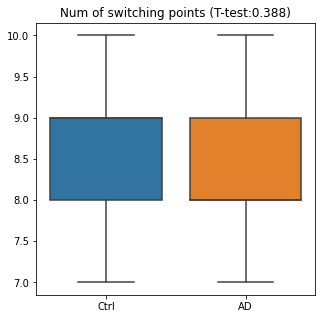

In [60]:
res = ttest_ind(ecptssCtrl_comU, ecptssAD_comU, equal_var=False)
plt.figure(figsize=[5, 5])
sns.boxplot(data=[ecptssCtrl_comU, ecptssAD_comU], showfliers=0)
plt.xticks([0, 1], ["Ctrl", "AD"])
plt.title(f"Num of switching points (T-test:{res.pvalue:.3f})")

### Analysis the two group separately.

In [28]:
AmatAD = GetAmat(dXmatsAD, XmatsAD, timeSpan, downrate=paras.downRate, fct=paras.fct, is_sum=True)
ResAD_ADU = GetNewData(dXmatsAD, XmatsAD, AmatAD, paras.r, True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [02:40<00:00,  1.82s/it]


In [29]:
canptssAD_ADU = Screening(ResAD_ADU.ndXmats, ResAD_ADU.nXmats, wh=paras.wh, showProgress=True)

Screening: 100%|██████████████████████████████████████████████████████████████████████████████████████| 88/88 [20:42<00:00, 14.11s/it]


In [30]:
detRessAD_ADU = []
for ix in trange(len(canptssAD_ADU)):
    res = EGenDy(ResAD_ADU.ndXmats[ix], ResAD_ADU.nXmats[ix], paras.kappa, Lmin=paras.Lmin, 
          canpts=canptssAD_ADU[ix], MaxM=paras.MaxM, is_full=False, 
          showProgress=False)
    detRessAD_ADU.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [56:50<00:00, 38.76s/it]


In [31]:
ecptssCtrl = [len(ix.mbic_ecpts) for ix in detRessCtrl]
ecptssAD_ADU = [len(ix.mbic_ecpts) for ix in detRessAD_ADU]

Text(0.5, 1.0, 'Num of switching points (T-test:0.938)')

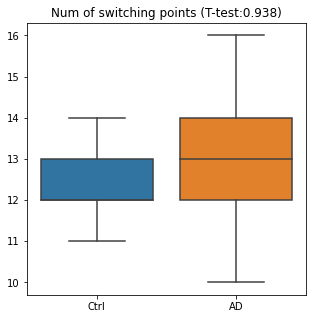

In [32]:
res = ttest_ind(ecptssCtrl, ecptssAD_ADU, equal_var=False)
plt.figure(figsize=[5, 5])
sns.boxplot(data=[ecptssCtrl, ecptssAD_ADU], showfliers=0)
plt.xticks([0, 1], ["Ctrl", "AD"])
plt.title(f"Num of switching points (T-test:{res.pvalue:.3f})")

### Compare AD and Ctrl Us

In [42]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
def minmax(x):
    rev = (x - np.min(x))/(np.max(x) - np.min(x))
    return rev

In [49]:
AmatAD = GetAmat(dXmatsAD, XmatsAD, timeSpan, downrate=paras.downRate, fct=paras.fct, is_sum=False)
ResAD = GetNewData(dXmatsAD, XmatsAD, AmatAD, paras.r, True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:16<00:00,  5.45it/s]


In [50]:
AmatCtrl = GetAmat(dXmatsCtrl, XmatsCtrl, timeSpan, downrate=paras.downRate, fct=paras.fct, is_sum=False)
ResCtrl = GetNewData(dXmatsCtrl, XmatsCtrl, AmatCtrl, paras.r, True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:15<00:00,  5.55it/s]


In [51]:
defNetsFil = list(dataDir.glob("DK_dic68.csv"))[0]
defNets = pd.read_csv(defNetsFil).T

mmDefNets = {}
for ix in range(defNets.shape[-1]):
    curCol = defNets[ix]
    mmDefNets[curCol[0]] = minmax(np.array(curCol[1:]))
kysOrd = sorted(mmDefNets.keys())

In [52]:
ADUs = np.abs(ResAD.eigVecs[:, ResAD.kpidxs])
corrMatAD = np.zeros((7, ADUs.shape[-1]))
for ix in range(ADUs.shape[-1]):
    curU = minmax(ADUs[:, ix])
    for iy, ky in enumerate(kysOrd):
        curV = mmDefNets[ky]
        corrMatAD[iy, ix] = pearsonr(curU, curV)[0]

In [53]:
CtrlUs = np.abs(ResCtrl.eigVecs[:, ResCtrl.kpidxs])
corrMatCtrl = np.zeros((7, CtrlUs.shape[-1]))
for ix in range(CtrlUs.shape[-1]):
    curU = minmax(CtrlUs[:, ix])
    for iy, ky in enumerate(kysOrd):
        curV = mmDefNets[ky]
        corrMatCtrl[iy, ix] = pearsonr(curU, curV)[0]

Text(0.5, 15.0, 'U')

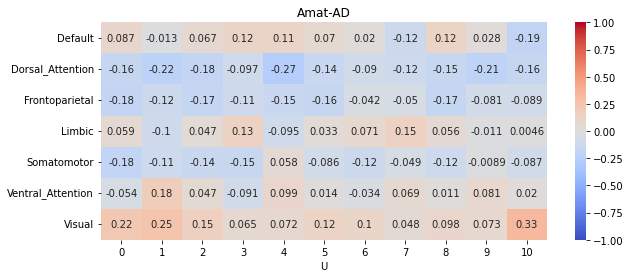

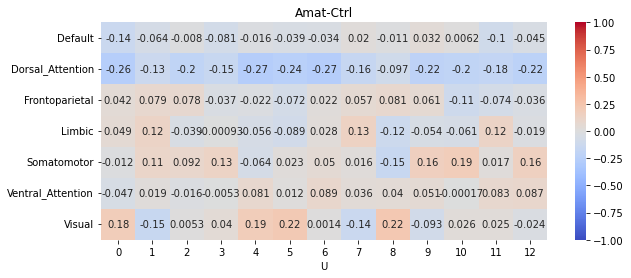

In [54]:
plt.figure(figsize=[10, 4])
plt.title("Amat-AD")
sns.heatmap(corrMatAD,  yticklabels=kysOrd, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=corrMatAD)
plt.xlabel("U")

plt.figure(figsize=[10, 4])
plt.title("Amat-Ctrl")
sns.heatmap(corrMatCtrl,  yticklabels=kysOrd, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=corrMatCtrl)
plt.xlabel("U")

#### save in brain

In [54]:
def reorderU(wU):
    wUreorder = np.zeros_like(wU, dtype=np.float64)
    wUreorder[0::2] = wU[:34]
    wUreorder[1::2] = wU[34:]
    return wUreorder

In [55]:
with open(dataDir/'BNVtemplate_DK68.txt', "r") as tf:
    DKtmplateRaw = tf.readlines()
DKtmplate = np.array([int(x.strip()) for x in DKtmplateRaw])

def U2BrainVec(wU):
    emVec = np.zeros_like(DKtmplate, dtype=np.float64)
    for idx in range(1, 69):
        emVec[DKtmplate==idx] = wU[idx-1]
    return emVec

In [56]:
curUs = CtrlUs
for ix in range(curUs.shape[-1]):
    curU = minmax(curUs[:, ix])
    outVec = U2BrainVec(reorderU(curU))
    np.savetxt(resDir/f"Ctrl_U_{ix}.txt", outVec)
    #np.savetxt(resDir/f"AD_U_{ix}.txt", outVec)

NameError: name 'CtrlUs' is not defined

In [33]:
np.savetxt("test.txt", outVec)

In [83]:
def GetAmatS(dXmat, Xmat):
    N, d, n = Xmats.shape
    Amat = np.zeros((d, d))
    kerdXmat = dXmat.T # n x d
    kerXmat = Xmat.T # n x d
    M = kerXmat.T.dot(kerXmat)/n
    XY = kerdXmat.T.dot(kerXmat)/n # it is Y\trans x X , formula is Amat = Y\trans X (X\trans X)^{-1}
    U, S, VT = np.linalg.svd(M)
    # Num of singular values to keep
    r = np.argmax(np.cumsum(S)/np.sum(S) >= 0.999) + 1 # For real data
    invM = VT.T[:, :r].dot(np.diag(1/S[:r])).dot(U.T[:r, :]) # M is symmetric and PSD
    Amat = XY.dot(invM)
    return Amat

In [85]:
Usall = []
r = 20
for ix in trange(70):
    curAmat = GetAmatS(dXmats[ix], Xmats[ix])
    eigVals, eigVecs = np.linalg.eig(curAmat)
    # sort the eigvs and eigvecs
    sidx = np.argsort(-np.abs(eigVals))
    eigVals = eigVals[sidx]
    eigVecs = eigVecs[:, sidx]
        
    # if breaking conjugate eigval pair, add r with 1
    if (eigVals[r-1].imag + eigVals[r].imag ) == 0:
        r = r + 1

    eigValsfull = np.concatenate([[np.Inf], eigVals])
    kpidxs = np.where(np.diff(np.abs(eigValsfull))[:r] != 0)[0]
    Usall.append(np.abs(eigVecs[:, kpidxs]))
    

100%|██████████| 70/70 [00:00<00:00, 166.26it/s]


In [105]:
from sklearn.cluster import KMeans
UsallArr = np.concatenate(Usall, axis=1).T
kmeans = KMeans(n_clusters=7, random_state=0).fit(UsallArr)

/home/huaqingj/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/huaqingj/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/huaqingj/anaconda3/lib/python3.7/site-

/home/huaqingj/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/huaqingj/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/huaqingj/anaconda3/lib/python3.7/site-

In [106]:
KCs = kmeans.cluster_centers_.T
corrMatKCs = np.zeros((7, KCs.shape[-1]))
for ix in range(KCs.shape[-1]):
    curU = minmax(KCs[:, ix])
    for iy, ky in enumerate(kysOrd):
        curV = mmDefNets[ky]
        corrMatKCs[iy, ix] = pearsonr(curU, curV)[0]

Text(0.5, 24.0, 'U')

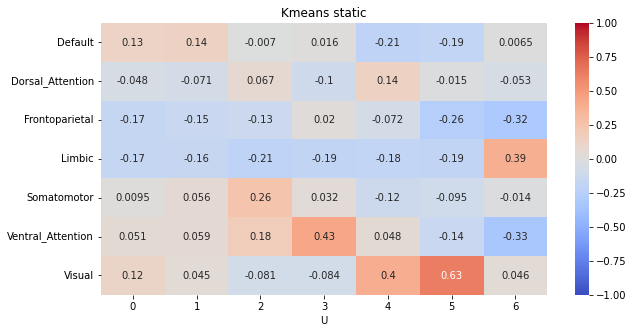

In [107]:
plt.figure(figsize=[10, 5])
plt.title("Kmeans static")
sns.heatmap(corrMatKCs,  yticklabels=kysOrd, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=corrMatKCs)
plt.xlabel("U")